# **Loan Default Prediction: Analyzing LendingClub Data**

## **1. Introduction**
LendingClub is a peer-to-peer lending platform that connects borrowers with investors. Investors seek to fund loans for borrowers who have a high probability of repayment. Accurately predicting loan repayment can help mitigate financial risks and optimize investment decisions.

In this project, we analyze lending data from 2007-2010 to classify whether a borrower fully repaid their loan or defaulted. We will explore key features affecting loan repayment, perform data preprocessing, and build predictive models to assess credit risk.


## **2. Dataset Overview**
We use publicly available data from LendingClub. This dataset provides key financial indicators that help assess loan repayment risk and includes borrower information, loan details, and repayment history. 

Below are the key features:

*Feature Descriptions*
- credit.policy: Binary indicator (1 = meets LendingClub’s credit underwriting criteria, 0 = does not meet).
- purpose: Categorical variable indicating the loan purpose (credit_card, debt_consolidation, educational, etc.).
- int.rate: Interest rate assigned to the borrower (e.g., 11% stored as 0.11). Higher rates indicate riskier borrowers.
- installment: Monthly installment amount the borrower needs to pay.
- log.annual.inc: Natural logarithm of the borrower’s annual income.
- dti: Debt-to-income ratio (total debt divided by annual income).
- fico: Borrower's FICO credit score.
- days.with.cr.line: Number of days the borrower has had a credit line.
- revol.bal: Revolving balance (amount unpaid at the end of a credit card billing cycle).
- revol.util: Revolving line utilization rate (credit used relative to available credit).
- inq.last.6mths: Number of times the borrower has had inquiries by creditors in the last 6 months.
- delinq.2yrs: Number of times the borrower was 30+ days past due on a payment in the past 2 years.
- pub.rec: Number of derogatory public records (e.g., bankruptcy filings, tax liens, or judgments).

## 3. Loading the Dataset and libraries

Before diving into analysis, we first load the necessary libraries and the dataset into a Pandas DataFrame. The dataset is stored in a CSV file, and we will read it using pandas.read_csv().

In [1]:
# Importing necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import plotly.express as px


In [41]:
# Path to your CSV file
file_path = '/kaggle/input/loan-data/loan_data.csv'

# Read the CSV file into a DataFrame
try:
    loan_data = pd.read_csv(file_path)
    print("Data loaded successfully.")
except FileNotFoundError:
    print("File not found. Please provide the correct file path.")

Data loaded successfully.


If the file path is correct, the dataset will load successfully. Otherwise, an error message will be displayed to help debug the issue. Next, let’s inspect the dataset to understand its structure.

Before proceeding with data preprocessing and modeling, we need to understand the structure and characteristics of our dataset. This involves:

- Displaying the first few rows to get a quick overview.
- Generating summary statistics for numerical columns.
- Checking the dataset's structure, including data types and missing values.

In [42]:
# Assign loan_data DataFrame to a new variable df
df = loan_data.copy()

# Display the first few rows of the DataFrame
print("\nFirst few rows of the DataFrame:")
print(df.head())

# Summary statistics of the DataFrame
print("\nSummary statistics of the DataFrame:")
print(df.describe())

# Information about the DataFrame
print("\nInformation about the DataFrame:")
print(df.info())


First few rows of the DataFrame:
   credit.policy             purpose  int.rate  installment  log.annual.inc  \
0              1  debt_consolidation    0.1189       829.10       11.350407   
1              1         credit_card    0.1071       228.22       11.082143   
2              1  debt_consolidation    0.1357       366.86       10.373491   
3              1  debt_consolidation    0.1008       162.34       11.350407   
4              1         credit_card    0.1426       102.92       11.299732   

     dti  fico  days.with.cr.line  revol.bal  revol.util  inq.last.6mths  \
0  19.48   737        5639.958333      28854        52.1               0   
1  14.29   707        2760.000000      33623        76.7               0   
2  11.63   682        4710.000000       3511        25.6               1   
3   8.10   712        2699.958333      33667        73.2               1   
4  14.97   667        4066.000000       4740        39.5               0   

   delinq.2yrs  pub.rec  not.fully

## **4. Data Preprocessing**

To ensure our dataset is ready for analysis and modeling, we start by converting categorical or binary numerical columns into appropriate data types.

Steps Taken:
- Convert the credit.policy and not.fully.paid columns from integers (0/1) to boolean values (True/False).
- Verify the changes by displaying the first few rows.
- Re-examine summary statistics and dataset information to confirm the conversion.

In [43]:
# Convert 'credit.policy' and 'not.fully.paid' columns to boolean type
df['credit.policy'] = df['credit.policy'].astype(bool)
df['not.fully.paid'] = df['not.fully.paid'].astype(bool)

# Display the first few rows of the DataFrame to verify the changes
print("\nFirst few rows of the DataFrame after conversion:")
print(df.head())

# Summary statistics of the DataFrame
print("\nSummary statistics of the DataFrame:")
print(df.describe())

# Information about the DataFrame
print("\nInformation about the DataFrame:")
print(df.info())


First few rows of the DataFrame after conversion:
   credit.policy             purpose  int.rate  installment  log.annual.inc  \
0           True  debt_consolidation    0.1189       829.10       11.350407   
1           True         credit_card    0.1071       228.22       11.082143   
2           True  debt_consolidation    0.1357       366.86       10.373491   
3           True  debt_consolidation    0.1008       162.34       11.350407   
4           True         credit_card    0.1426       102.92       11.299732   

     dti  fico  days.with.cr.line  revol.bal  revol.util  inq.last.6mths  \
0  19.48   737        5639.958333      28854        52.1               0   
1  14.29   707        2760.000000      33623        76.7               0   
2  11.63   682        4710.000000       3511        25.6               1   
3   8.10   712        2699.958333      33667        73.2               1   
4  14.97   667        4066.000000       4740        39.5               0   

   delinq.2yrs  p

*Why This Matters:*

- Converting these columns to boolean improves readability and prevents unintended numerical computations.
- It ensures consistency when analyzing categorical features in later stages.

*To better understand the distribution of key categorical features, we analyze the frequency of unique values in the following columns:*

- inq.last.6mths: Number of times a borrower had a credit inquiry in the last six months.
- delinq.2yrs: Number of times the borrower was delinquent (30+ days past due) in the past two years.
- pub.rec: Number of public derogatory records (e.g., bankruptcies, tax liens, judgments).

***Computing Unique Values and Their Frequencies***

The following code calculates the unique values, their counts, and their percentage representation in the dataset.

In [44]:
# Calculate unique values and their counts for the specified features
inq_counts = df['inq.last.6mths'].value_counts(normalize=False).sort_index()
delinq_counts = df['delinq.2yrs'].value_counts(normalize=False).sort_index()
pub_rec_counts = df['pub.rec'].value_counts(normalize=False).sort_index()

# Print sorted unique values, counts, and percentages for each feature
print("Unique values, counts, and percentages for 'inq.last.6mths':")
for value, count, percentage in zip(inq_counts.index, inq_counts.values, inq_counts.values / len(df)):
    print(f"{value}: Count: {count}, Percentage: {percentage*100:.2f}%")

print("\nUnique values, counts, and percentages for 'delinq.2yrs':")
for value, count, percentage in zip(delinq_counts.index, delinq_counts.values, delinq_counts.values / len(df)):
    print(f"{value}: Count: {count}, Percentage: {percentage*100:.2f}%")

print("\nUnique values, counts, and percentages for 'pub.rec':")
for value, count, percentage in zip(pub_rec_counts.index, pub_rec_counts.values, pub_rec_counts.values / len(df)):
    print(f"{value}: Count: {count}, Percentage: {percentage*100:.2f}%")

Unique values, counts, and percentages for 'inq.last.6mths':
0: Count: 3637, Percentage: 37.97%
1: Count: 2462, Percentage: 25.70%
2: Count: 1384, Percentage: 14.45%
3: Count: 864, Percentage: 9.02%
4: Count: 475, Percentage: 4.96%
5: Count: 278, Percentage: 2.90%
6: Count: 165, Percentage: 1.72%
7: Count: 100, Percentage: 1.04%
8: Count: 72, Percentage: 0.75%
9: Count: 47, Percentage: 0.49%
10: Count: 23, Percentage: 0.24%
11: Count: 15, Percentage: 0.16%
12: Count: 15, Percentage: 0.16%
13: Count: 6, Percentage: 0.06%
14: Count: 6, Percentage: 0.06%
15: Count: 9, Percentage: 0.09%
16: Count: 3, Percentage: 0.03%
17: Count: 2, Percentage: 0.02%
18: Count: 4, Percentage: 0.04%
19: Count: 2, Percentage: 0.02%
20: Count: 1, Percentage: 0.01%
24: Count: 2, Percentage: 0.02%
25: Count: 1, Percentage: 0.01%
27: Count: 1, Percentage: 0.01%
28: Count: 1, Percentage: 0.01%
31: Count: 1, Percentage: 0.01%
32: Count: 1, Percentage: 0.01%
33: Count: 1, Percentage: 0.01%

Unique values, counts, an

*Why This Matters:*

Helps identify imbalances in the dataset that could affect model training.
Understanding the frequency of delinquencies and public records can help determine their impact on loan repayment.
Useful for deciding feature transformations or binning strategies for better model performance.
In the next step, we will visualize these distributions for deeper insights.

### **4.1 Feature Binning for Discrete Variables**

To manage skewed distributions and improve model generalization, we apply custom binning strategies to the following categorical features:
- inq.last.6mths (Inquiries in the last 6 months)
- delinq.2yrs (Delinquencies in the past 2 years)
- pub.rec (Public derogatory records)

#### ***Custom Binning Logic***
1. inq.last.6mths (Credit Inquiries in Last 6 Months)
- bin1: 0 inquiries
- bin2: 1-2 inquiries
- bin3: 3-5 inquiries
- bin4: More than 5 inquiries


In [45]:
# Define the custom binning function
def custom_binning(value):
    if value == 0:
        return 'bin1'
    elif value in [1, 2]:
        return 'bin2'
    elif value in [3, 4, 5]:
        return 'bin3'
    else:
        return 'bin4'

# Apply the custom binning function to 'inq.last.6mths' feature
df['inq_bins'] = df['inq.last.6mths'].apply(custom_binning)

# Calculate distribution of new discrete labels with counts and percentages
inq_bins_distribution = df['inq_bins'].value_counts(normalize=True)

# Print distribution of new discrete labels with counts and percentages
print("Distribution of new discrete labels ('inq_bins') with counts and percentages:")
print(inq_bins_distribution * 100)
print("\nCounts:")
print(df['inq_bins'].value_counts())

Distribution of new discrete labels ('inq_bins') with counts and percentages:
inq_bins
bin2    40.154521
bin1    37.972437
bin3    16.882439
bin4     4.990603
Name: proportion, dtype: float64

Counts:
inq_bins
bin2    3846
bin1    3637
bin3    1617
bin4     478
Name: count, dtype: int64


2. delinq.2yrs (Delinquencies in Last 2 Years)
 - bin1: 0 delinquencies
 - bin2: 1 delinquency
 - bin3: 2 or more delinquencies

In [46]:
# Define the custom binning function
def custom_binning_delinq(value):
    if value == 0:
        return 'bin1'
    elif value == 1:
        return 'bin2'
    else:
        return 'bin3'

# Apply the custom binning function to 'delinq.2yrs' feature
df['delinq_bins'] = df['delinq.2yrs'].apply(custom_binning_delinq)

# Calculate distribution of new discrete labels with counts and percentages
delinq_bins_distribution = df['delinq_bins'].value_counts(normalize=True)

# Print distribution of new discrete labels with counts and percentages
print("Distribution of new discrete labels ('delinq_bins') with counts and percentages:")
print(delinq_bins_distribution * 100)
print("\nCounts:")
print(df['delinq_bins'].value_counts())

Distribution of new discrete labels ('delinq_bins') with counts and percentages:
delinq_bins
bin1    88.306536
bin2     8.686573
bin3     3.006891
Name: proportion, dtype: float64

Counts:
delinq_bins
bin1    8458
bin2     832
bin3     288
Name: count, dtype: int64


3. pub.rec (Public Records)
- bin1: 0 public records
- bin2: 1 or more public records

In [47]:
# Define the custom binning function
def custom_binning_pub_rec(value):
    if value == 0:
        return 'bin1'
    else:
        return 'bin2'

# Apply the custom binning function to 'pub.rec' feature
df['pub_rec_bins'] = df['pub.rec'].apply(custom_binning_pub_rec)

# Calculate distribution of new discrete labels with counts and percentages
pub_rec_bins_distribution = df['pub_rec_bins'].value_counts(normalize=True)

# Print distribution of new discrete labels with counts and percentages
print("Distribution of new discrete labels ('pub_rec_bins') with counts and percentages:")
print(pub_rec_bins_distribution * 100)
print("\nCounts:")
print(df['pub_rec_bins'].value_counts())

Distribution of new discrete labels ('pub_rec_bins') with counts and percentages:
pub_rec_bins
bin1    94.163708
bin2     5.836292
Name: proportion, dtype: float64

Counts:
pub_rec_bins
bin1    9019
bin2     559
Name: count, dtype: int64


*Why Use Binning?*

- Reduces noise in continuous categorical data.
- Prevents overfitting in machine learning models.
- Enhances interpretability by grouping values into meaningful categories.
- Balances class distributions, making the model learn better from imbalanced data.

## **5. Data Visualization - Exploratory Data Analysis**

***Visualizing the Distribution of Categorical Features***

To gain insights into the distribution of categorical features in our dataset, we will plot bar charts for each categorical column. Categorical features are those that are either of object type (e.g., string) or boolean type. Visualizing these features helps us understand the distribution and frequency of different categories.

We will use Seaborn's countplot to display the count of each category for the relevant features. Additionally, we'll add count labels on top of the bars for better clarity.

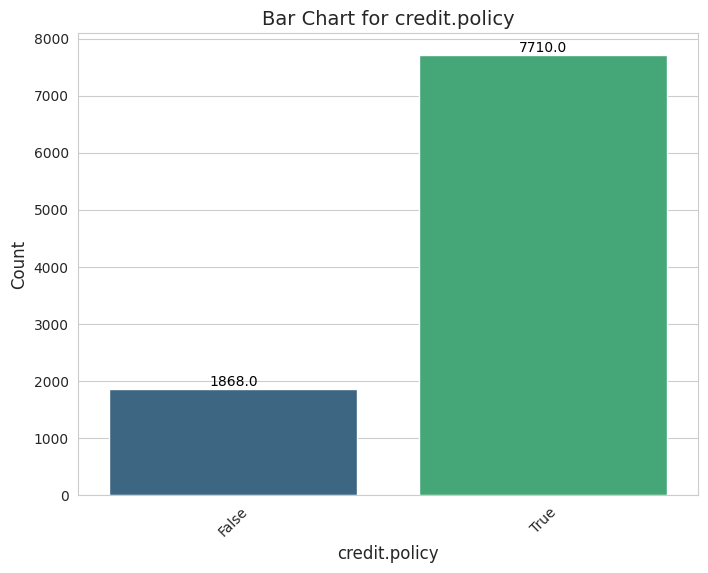

In [48]:
# Set visualization style
sns.set_style("whitegrid")

# Identify the first categorical column (modify as needed)
col = df.select_dtypes(include=['object', 'bool']).columns[0]

# Plot bar chart for the first categorical column
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x=col, palette="viridis")

# Add count labels
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=10, color='black')

plt.title(f'Bar Chart for {col}', fontsize=14)
plt.xlabel(col, fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)

plt.show()  # Display the plot


***Key Observations:***

- The chart shows two bars representing the counts of customers who meet (1) and do not meet (0) the credit policy criteria.
- The bar for 1 (meets criteria) is significantly higher (7710) compared to the bar for 0 (1868), indicating that most customers in the dataset meet the credit policy criteria.

***Insights:***

- The dataset is imbalanced with respect to credit.policy, as the majority of customers meet the criteria.
- This imbalance might affect model performance, especially if the target variable (loan default) is also imbalanced.

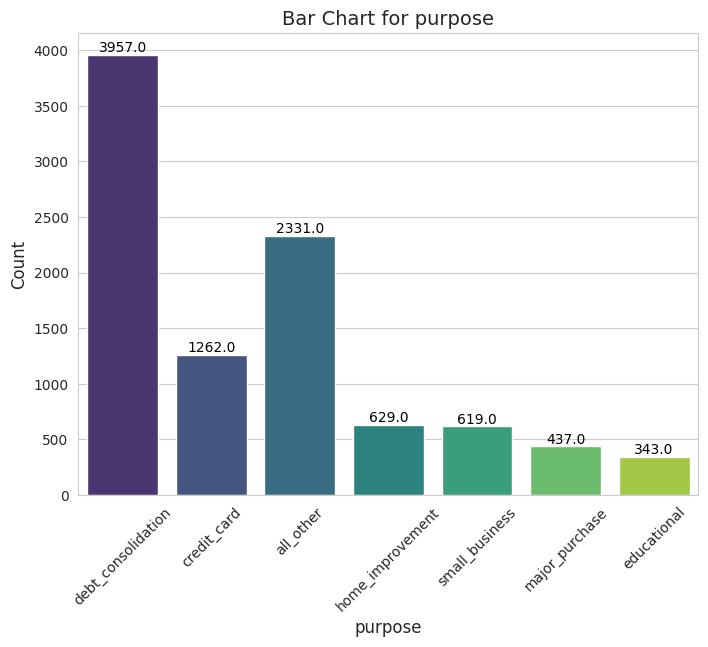

In [49]:
# Set visualization style
sns.set_style("whitegrid")

# Identify the second categorical column (modify as needed)
col = df.select_dtypes(include=['object', 'bool']).columns[1]

# Plot bar chart for the second categorical column
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x=col, palette="viridis")

# Add count labels
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=10, color='black')

plt.title(f'Bar Chart for {col}', fontsize=14)
plt.xlabel(col, fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)

plt.show()  # Display the plot


***Key Observations:***

- The most common loan purpose is debt consolidation (3957), followed by credit_card (2331) and all_other (1262).
- The least common loan purposes are educational (343) and major_purchase (437).

***Insights:***

- Debt consolidation and credit card payments are the primary reasons for taking loans, indicating that customers are likely using loans to manage existing debts.
- Loans for educational purposes are the least common, suggesting that this category might not be a significant driver in the dataset.

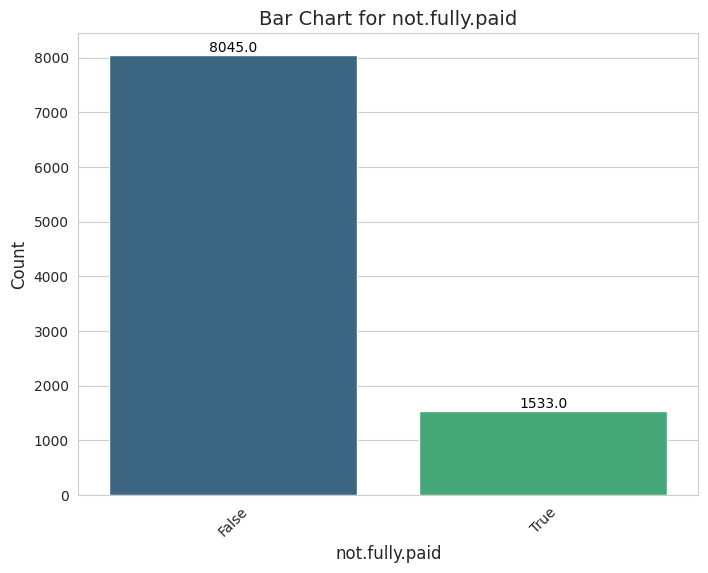

In [50]:
# Set visualization style
sns.set_style("whitegrid")

# Identify the third categorical column (modify as needed)
col = df.select_dtypes(include=['object', 'bool']).columns[2]

# Plot bar chart for the third categorical column
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x=col, palette="viridis")

# Add count labels
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=10, color='black')

plt.title(f'Bar Chart for {col}', fontsize=14)
plt.xlabel(col, fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)

plt.show()  # Display the plot


***Key Observations:***

- The bar for 0 (fully paid) is significantly higher (8045) compared to the bar for 1 (not fully paid, 1533), indicating that most loans in the dataset have been fully paid.
- The dataset is imbalanced, with a majority of loans being fully paid.

***Insights:***
- The imbalance in the target variable (not.fully.paid) suggests that the model might be biased towards predicting the majority class (fully paid loans).
- This imbalance could affect the model's ability to accurately predict loan defaults (not fully paid).

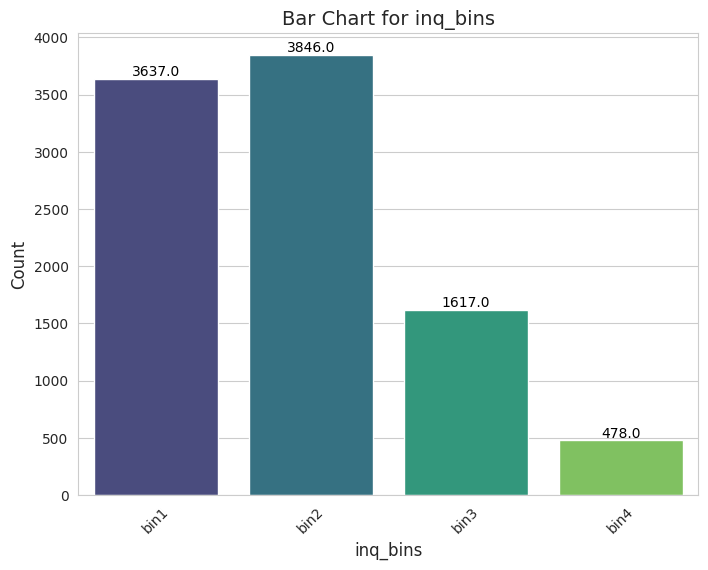

In [51]:
# Set visualization style
sns.set_style("whitegrid")

# Identify the fourth categorical column (modify as needed)
col = df.select_dtypes(include=['object', 'bool']).columns[3]

# Plot bar chart for the fourth categorical column
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x=col, palette="viridis")

# Add count labels
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=10, color='black')

plt.title(f'Bar Chart for {col}', fontsize=14)
plt.xlabel(col, fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)

plt.show()  # Display the plot


***Key Observations:***

- The chart shows four bins, with bin1 (3637) and bin2 (3846) having the highest counts, indicating that most customers fall into these lower inquiry count categories.
- bin3 (1617) and bin4 (478) have progressively fewer counts, suggesting that fewer customers have higher numbers of credit inquiries.

***Insights:***

- The majority of customers have a low number of credit inquiries, which might indicate lower credit risk.
- Customers in bin4 (highest inquiry count) are relatively rare, which could suggest higher credit risk or financial stress.

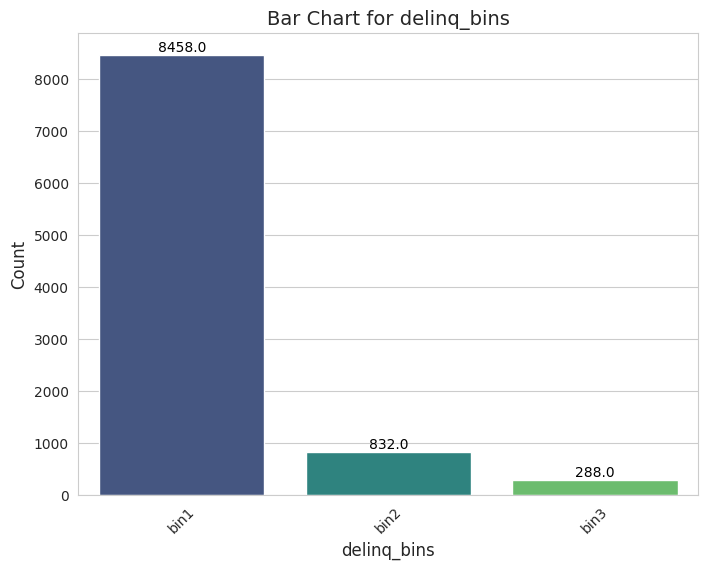

In [52]:
# Set visualization style
sns.set_style("whitegrid")

# Identify the fifth categorical column (modify as needed)
col = df.select_dtypes(include=['object', 'bool']).columns[4]

# Plot bar chart for the fifth categorical column
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x=col, palette="viridis")

# Add count labels
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=10, color='black')

plt.title(f'Bar Chart for {col}', fontsize=14)
plt.xlabel(col, fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)

plt.show()  # Display the plot


***Key Observations:***

- The chart shows three bins, with the first bin (8458) having the highest count, indicating that most customers have no or very few delinquencies.
- The second bin (832) and third bin (288) have progressively fewer counts, suggesting that fewer customers have higher numbers of delinquencies.

***Insights:***

- The majority of customers have no or very few delinquencies, which might indicate lower credit risk.
- Customers in the higher delinquency bins (second and third bins) are relatively rare, which could suggest higher credit risk or financial stress.

***Handling Outliers in 'revol.util' Feature***

The 'revol.util' feature represents the revolving credit utilization percentage, which is a measure of the amount of credit being used relative to the total available credit. 
- A value greater than 100% is not realistic, as it indicates that the individual is using more credit than they have available, which is an unusual scenario.

To ensure data integrity and consistency, we will:

- Identify records where 'revol.util' is greater than 100%.
- Modify those records to set 'revol.util' values greater than 100% to 100%.
- This is a data cleaning step to handle any anomalies in the dataset.

In [53]:
# Filter the DataFrame for records where 'revol.util' is greater than 100%
revol_util_over_100 = df[df['revol.util'] > 100]

# Display the filtered DataFrame
print("Records where 'revol.util' is greater than 100%:")
print(revol_util_over_100)

Records where 'revol.util' is greater than 100%:
      credit.policy             purpose  int.rate  installment  \
7777          False         credit_card    0.1438        42.96   
7895          False  debt_consolidation    0.1438       149.48   
7914          False  debt_consolidation    0.1186        23.21   
7922          False         credit_card    0.1438       359.95   
7923          False           all_other    0.0933       287.59   
7957          False  debt_consolidation    0.1786        88.41   
7982          False         credit_card    0.1438       137.45   
7991          False           all_other    0.0996        51.60   
8056          False           all_other    0.1059        78.11   
8073          False         educational    0.1375       495.52   
8091          False  debt_consolidation    0.1691       154.90   
8129          False  debt_consolidation    0.1583       701.47   
8176          False  debt_consolidation    0.1425       171.50   
8187          False        

In [54]:
# Filter the DataFrame for records where 'revol.util' is greater than 100%
revol_util_over_100_indices = df[df['revol.util'] > 100].index

# Modify the 'revol.util' values greater than 100 to 100
df.loc[revol_util_over_100_indices, 'revol.util'] = 100

# Display the modified records
print("Modified records where 'revol.util' was greater than 100%:")
print(df.loc[revol_util_over_100_indices])

Modified records where 'revol.util' was greater than 100%:
      credit.policy             purpose  int.rate  installment  \
7777          False         credit_card    0.1438        42.96   
7895          False  debt_consolidation    0.1438       149.48   
7914          False  debt_consolidation    0.1186        23.21   
7922          False         credit_card    0.1438       359.95   
7923          False           all_other    0.0933       287.59   
7957          False  debt_consolidation    0.1786        88.41   
7982          False         credit_card    0.1438       137.45   
7991          False           all_other    0.0996        51.60   
8056          False           all_other    0.1059        78.11   
8073          False         educational    0.1375       495.52   
8091          False  debt_consolidation    0.1691       154.90   
8129          False  debt_consolidation    0.1583       701.47   
8176          False  debt_consolidation    0.1425       171.50   
8187          Fal

- Filtering Records: The first line filters the DataFrame for records where the 'revol.util' value is greater than 100%. These records are stored in the revol_util_over_100 variable.

- Displaying Filtered Records: The filtered records are printed out for inspection to ensure that only the relevant rows are being targeted.

- Identifying the Indices: We extract the indices of the rows where 'revol.util' exceeds 100%, which allows us to later modify only those specific rows.

- Modifying the Values: Using .loc[], we modify the 'revol.util' values greater than 100% to 100%. This step corrects any unrealistic values.

- Displaying Modified Records: After making the changes, we print out the modified records to confirm that the updates were applied correctly.

Identifying Numerical Columns: We select all columns with integer (int) and floating-point (float) data types from the DataFrame. These columns represent the numerical features that will be analyzed.

Plotting Histograms: For each numerical column:

- We create a new figure with a size of 8x6.
- The plt.hist() function is used to plot the histogram with 20 bins, colored in skyblue, and with a black edge around each bin for better visibility.


Customization:

- We add a title to the histogram using plt.title().
- The xlabel() and ylabel() functions are used to label the x-axis (representing the feature name) and the y-axis (representing the frequency of data points in each bin).
- The grid is turned on to make the histogram easier to interpret.

***Visualizing the Distribution of Numerical Features***

To gain insights into the distribution of numerical variables, we will plot histograms for each numerical feature. Histograms provide a visual representation of the frequency of data points within different ranges (bins). This helps in understanding the spread, central tendency, and presence of any skewness or outliers in the data.

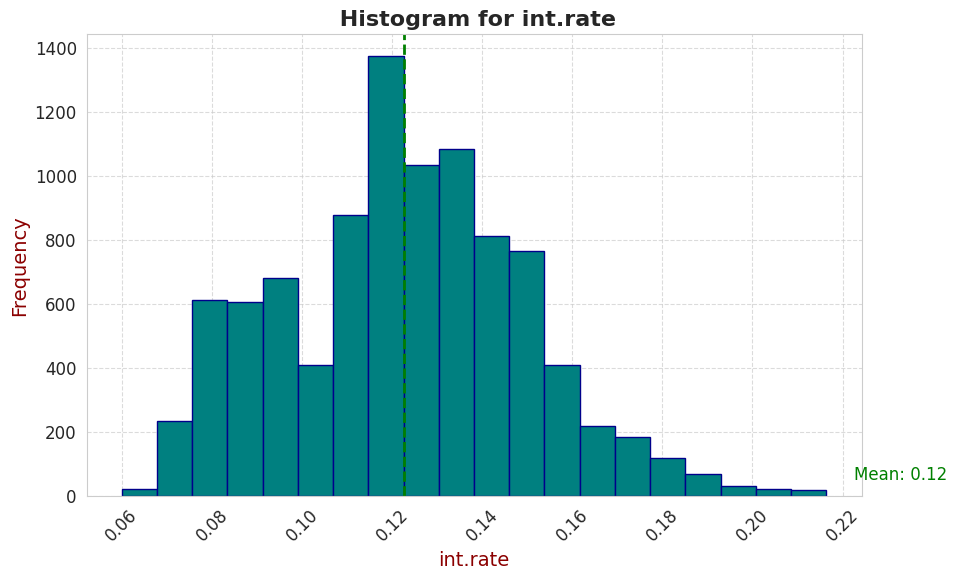

In [55]:
# Set the first numerical column (modify as needed)
col = df.select_dtypes(include=['int', 'float']).columns[0]

# Plot histogram for the first numerical column with improvements
plt.figure(figsize=(10, 6))

# Use a more appealing color palette and adjust the edge color
plt.hist(df[col], bins=20, color='teal', edgecolor='darkblue')

# Add title with custom font size and weight
plt.title(f' Histogram for {col}', fontsize=16, fontweight='bold')

# Label x and y axes with increased font size and a different color
plt.xlabel(col, fontsize=14, color='darkred')
plt.ylabel('Frequency', fontsize=14, color='darkred')

# Adjust the x-axis and y-axis ticks for better readability
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

# Add a grid for better readability of bars and set the grid style
plt.grid(True, linestyle='--', alpha=0.7)

# Add a vertical line for mean or median (optional)
mean_value = df[col].mean()
plt.axvline(mean_value, color='green', linestyle='dashed', linewidth=2)
plt.text(mean_value + 0.1, 50, f'Mean: {mean_value:.2f}', color='green', fontsize=12)

# Display the plot
plt.show()


***Purpose of the Chart:***
- The histogram visualizes the distribution of the int.rate (interest rate) feature, showing how frequently different interest rates occur in the dataset.

***Key Observations:***

- The mean interest rate is 0.12 (12%), which provides a central tendency measure for the distribution.
- The histogram shows the frequency of interest rates across different bins, indicating how concentrated or spread out the interest rates are.

***Insights:***

- The distribution of interest rates can help identify common ranges and outliers. For example, if the histogram is skewed, it might indicate that most loans have lower interest rates with a few exceptions.

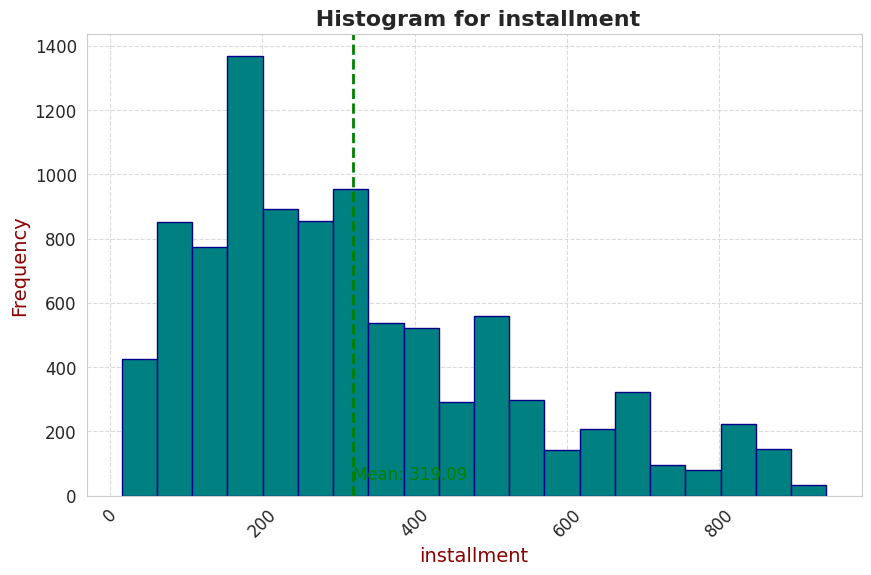

In [56]:
# Set the first numerical column (modify as needed)
col = df.select_dtypes(include=['int', 'float']).columns[1]

# Plot histogram for the first numerical column with improvements
plt.figure(figsize=(10, 6))

# Use a more appealing color palette and adjust the edge color
plt.hist(df[col], bins=20, color='teal', edgecolor='darkblue')

# Add title with custom font size and weight
plt.title(f' Histogram for {col}', fontsize=16, fontweight='bold')

# Label x and y axes with increased font size and a different color
plt.xlabel(col, fontsize=14, color='darkred')
plt.ylabel('Frequency', fontsize=14, color='darkred')

# Adjust the x-axis and y-axis ticks for better readability
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

# Add a grid for better readability of bars and set the grid style
plt.grid(True, linestyle='--', alpha=0.7)

# Add a vertical line for mean or median (optional)
mean_value = df[col].mean()
plt.axvline(mean_value, color='green', linestyle='dashed', linewidth=2)
plt.text(mean_value + 0.1, 50, f'Mean: {mean_value:.2f}', color='green', fontsize=12)

# Display the plot
plt.show()


***Purpose of the Chart:***
The histogram visualizes the distribution of the installment feature, which represents the monthly payment amount for loans.

***Key Observations:***
- Mean Installment: The average monthly installment is 319.09, indicating the central tendency of the distribution.

- Frequency Distribution: The highest frequency of installments falls within the range of 200 to 300, with a peak around this range.
- The frequency gradually decreases as the installment amount increases beyond 300, with fewer loans having higher monthly payments (e.g., above 400).

***Insights:***
- Most Common Installment Range: The majority of loans have monthly installments between 200 and 300, suggesting that this is a typical affordability range for borrowers.
- Tail of the Distribution: The histogram has a right tail, indicating that while most loans have lower installments, there are some loans with significantly higher monthly payments (e.g., above 400).
-These higher installments might represent larger loans or loans with shorter repayment terms.
- Implications for Loan Default: Higher installments could strain borrowers' finances, potentially increasing the risk of default.
- Loans with installments in the lower range (e.g., 200–300) might have a lower risk of default due to their affordability.



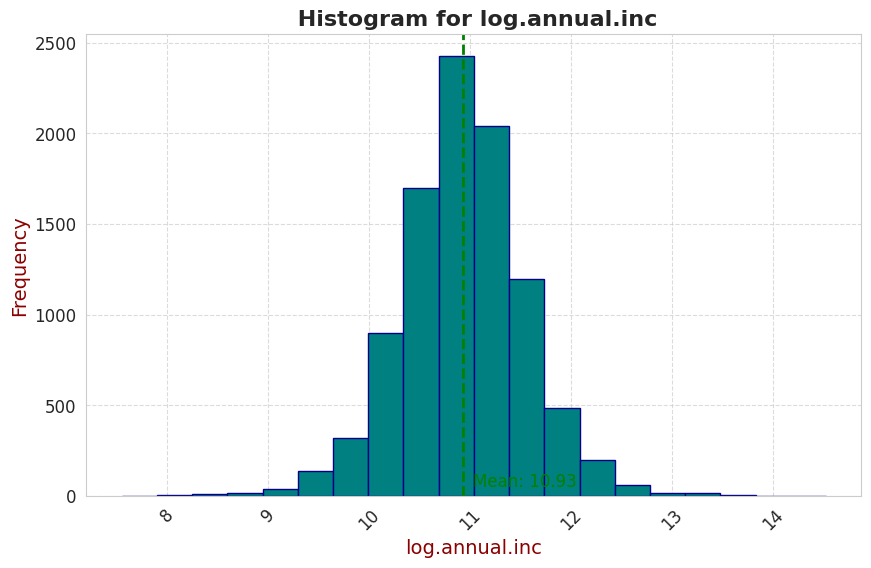

In [57]:
# Set the first numerical column (modify as needed)
col = df.select_dtypes(include=['int', 'float']).columns[2]

# Plot histogram for the first numerical column with improvements
plt.figure(figsize=(10, 6))

# Use a more appealing color palette and adjust the edge color
plt.hist(df[col], bins=20, color='teal', edgecolor='darkblue')

# Add title with custom font size and weight
plt.title(f' Histogram for {col}', fontsize=16, fontweight='bold')

# Label x and y axes with increased font size and a different color
plt.xlabel(col, fontsize=14, color='darkred')
plt.ylabel('Frequency', fontsize=14, color='darkred')

# Adjust the x-axis and y-axis ticks for better readability
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

# Add a grid for better readability of bars and set the grid style
plt.grid(True, linestyle='--', alpha=0.7)

# Add a vertical line for mean or median (optional)
mean_value = df[col].mean()
plt.axvline(mean_value, color='green', linestyle='dashed', linewidth=2)
plt.text(mean_value + 0.1, 50, f'Mean: {mean_value:.2f}', color='green', fontsize=12)

# Display the plot
plt.show()


***Purpose of the Chart***:
- The histogram visualizes the distribution of the `log.annual.inc` feature, which represents the logarithm of annual income. This transformation is often used to normalize income data and reduce skewness.

***Key Observations***:
- **Mean Log Income**: The mean log-transformed annual income is **10.93**, which, when exponentiated (e^10.93), translates to approximately **56,000** (assuming natural log). This provides a central tendency measure for the distribution.
- **Frequency Distribution**:
  - The histogram likely shows a bell-shaped or approximately normal distribution, as log transformation is often used to achieve normality in skewed data.
  - The majority of borrowers fall within a specific range of log income, with frequencies tapering off on both ends (lower and higher incomes).

***Insights***:
1. **Income Distribution**:
   - The log transformation suggests that the raw annual income data was likely right-skewed, with a few high-income outliers.
   - The transformed data now shows a more symmetric distribution, making it easier to analyze and model.

2. **Typical Borrower Income**:
   - Most borrowers have log incomes clustered around the mean (**10.93**), indicating that the majority of borrowers earn incomes close to the median range.
   - Borrowers with extremely high or low log incomes are less common, as indicated by the tapering ends of the histogram.

3. **Implications for Loan Default**:
   - Borrowers with lower log incomes (e.g., below the mean) might be at higher risk of default due to limited financial resources.
   - Borrowers with higher log incomes (e.g., above the mean) might have a lower risk of default, as they likely have better financial stability.

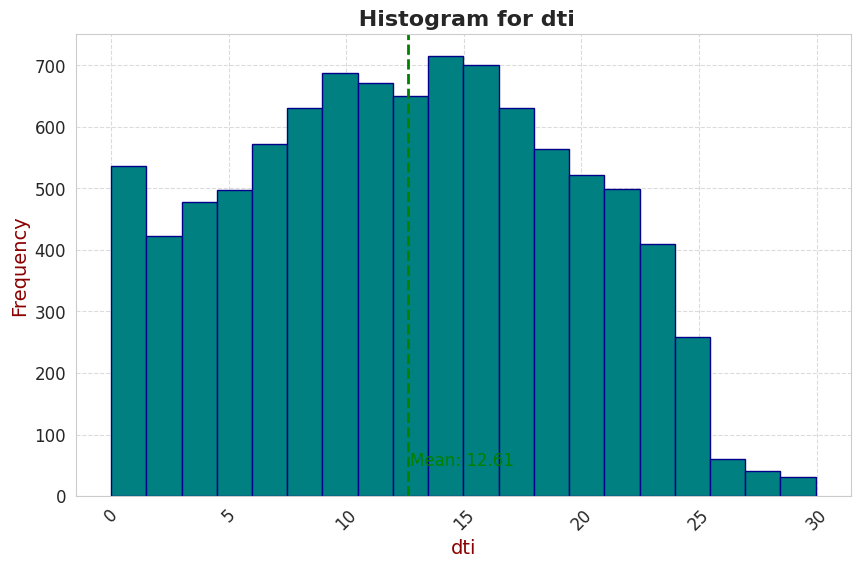

In [58]:
# Set the first numerical column (modify as needed)
col = df.select_dtypes(include=['int', 'float']).columns[3]

# Plot histogram for the first numerical column with improvements
plt.figure(figsize=(10, 6))

# Use a more appealing color palette and adjust the edge color
plt.hist(df[col], bins=20, color='teal', edgecolor='darkblue')

# Add title with custom font size and weight
plt.title(f' Histogram for {col}', fontsize=16, fontweight='bold')

# Label x and y axes with increased font size and a different color
plt.xlabel(col, fontsize=14, color='darkred')
plt.ylabel('Frequency', fontsize=14, color='darkred')

# Adjust the x-axis and y-axis ticks for better readability
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

# Add a grid for better readability of bars and set the grid style
plt.grid(True, linestyle='--', alpha=0.7)

# Add a vertical line for mean or median (optional)
mean_value = df[col].mean()
plt.axvline(mean_value, color='green', linestyle='dashed', linewidth=2)
plt.text(mean_value + 0.1, 50, f'Mean: {mean_value:.2f}', color='green', fontsize=12)

# Display the plot
plt.show()


***Purpose of the Chart***:
- The histogram visualizes the distribution of the `dti` (debt-to-income ratio) feature, which measures the percentage of a borrower's monthly income that goes toward paying debts.

***Key Observations***:
- **Mean DTI**: The mean debt-to-income ratio is **12.61**, indicating that, on average, borrowers spend **12.61%** of their monthly income on debt payments.
- **Frequency Distribution**:
  - The histogram likely shows a right-skewed distribution, with most borrowers having lower DTI values and fewer borrowers having higher DTI values.
  - The highest frequency of borrowers falls within a specific range of lower DTI values (e.g., **0–20**).

***Insights***:
1. **Typical Borrower DTI**:
   - Most borrowers have a DTI below **20**, suggesting that the majority of borrowers have manageable debt levels relative to their income.
   - Borrowers with very high DTI values (e.g., above **30**) are less common, as indicated by the tapering tail of the histogram.

2. **Implications for Loan Default**:
   - Borrowers with higher DTI values are likely at greater risk of default, as a larger portion of their income is already allocated to debt payments.
   - Borrowers with lower DTI values are likely at lower risk of default, as they have more disposable income to manage loan repayments.

3. **Outliers and Skewness**:
   - The right-skewed distribution indicates that while most borrowers have low to moderate DTI values, there are some outliers with significantly higher DTI values.
   - These outliers might represent borrowers with high financial stress, who could be more likely to default on loans.

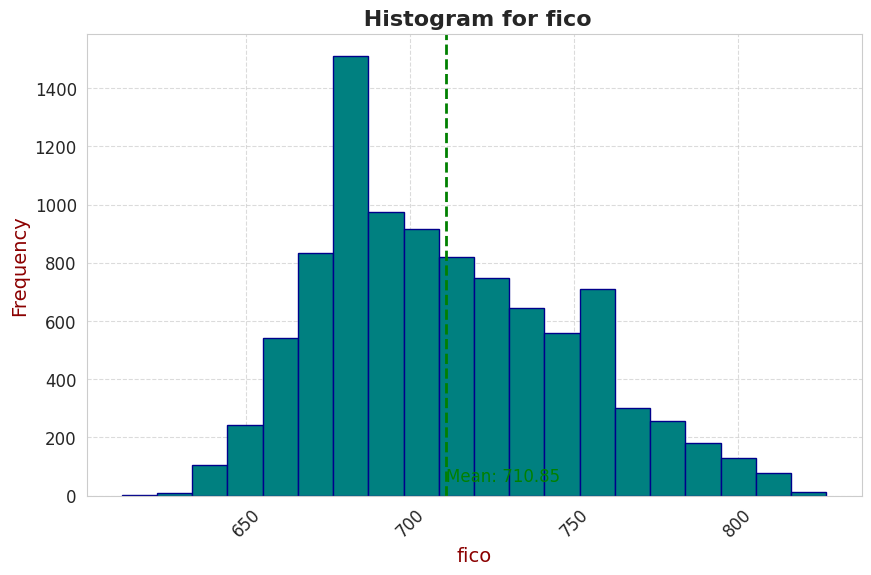

In [59]:
# 
col = df.select_dtypes(include=['int', 'float']).columns[4]

# Plot histogram for the first numerical column with improvements
plt.figure(figsize=(10, 6))

# Use a more appealing color palette and adjust the edge color
plt.hist(df[col], bins=20, color='teal', edgecolor='darkblue')

# Add title with custom font size and weight
plt.title(f' Histogram for {col}', fontsize=16, fontweight='bold')

# Label x and y axes with increased font size and a different color
plt.xlabel(col, fontsize=14, color='darkred')
plt.ylabel('Frequency', fontsize=14, color='darkred')

# Adjust the x-axis and y-axis ticks for better readability
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

# Add a grid for better readability of bars and set the grid style
plt.grid(True, linestyle='--', alpha=0.7)

# Add a vertical line for mean or median (optional)
mean_value = df[col].mean()
plt.axvline(mean_value, color='green', linestyle='dashed', linewidth=2)
plt.text(mean_value + 0.1, 50, f'Mean: {mean_value:.2f}', color='green', fontsize=12)

# Display the plot
plt.show()


**Purpose of the Chart***:
- The histogram visualizes the distribution of the `fico` feature, which represents the FICO credit score of borrowers. FICO scores are a key indicator of creditworthiness.

***Key Observations***:
- **Mean FICO Score**: The mean FICO score is **710.85**, indicating that, on average, borrowers in the dataset have good credit scores (FICO scores typically range from 300 to 850).
- **Frequency Distribution**:
  - The histogram likely shows a bell-shaped or approximately normal distribution, with most borrowers having FICO scores clustered around the mean.
  - The frequencies taper off on both ends (lower and higher FICO scores), indicating fewer borrowers with very low or very high scores.

***Insights***:
1. **Typical Borrower Creditworthiness**:
   - Most borrowers have FICO scores in the range of **650–750**, which is considered good to very good credit.
   - Borrowers with FICO scores below **650** (fair or poor credit) are less common, as are those with scores above **750** (excellent credit).

2. **Implications for Loan Default**:
   - Borrowers with lower FICO scores (e.g., below **650**) are likely at higher risk of default, as they may have a history of credit issues or financial instability.
   - Borrowers with higher FICO scores (e.g., above **750**) are likely at lower risk of default, as they have a strong credit history and are considered more reliable.

3. **Distribution Shape**:
   - The bell-shaped distribution suggests that the dataset is well-represented across a range of credit scores, with no extreme skewness.
   - The concentration of scores around the mean indicates that the majority of borrowers have similar levels of creditworthiness.

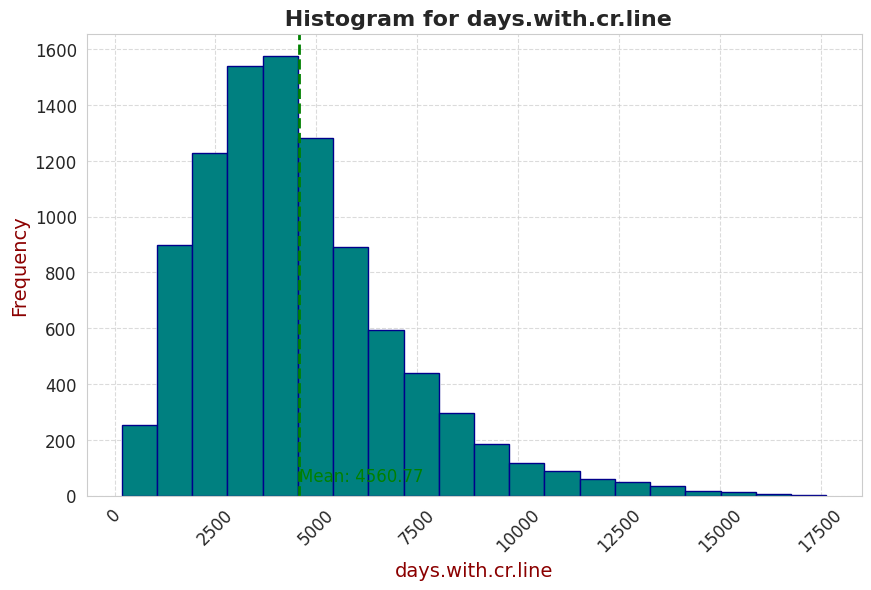

In [60]:
# 
col = df.select_dtypes(include=['int', 'float']).columns[5]

# Plot histogram for the first numerical column with improvements
plt.figure(figsize=(10, 6))

# Use a more appealing color palette and adjust the edge color
plt.hist(df[col], bins=20, color='teal', edgecolor='darkblue')

# Add title with custom font size and weight
plt.title(f' Histogram for {col}', fontsize=16, fontweight='bold')

# Label x and y axes with increased font size and a different color
plt.xlabel(col, fontsize=14, color='darkred')
plt.ylabel('Frequency', fontsize=14, color='darkred')

# Adjust the x-axis and y-axis ticks for better readability
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

# Add a grid for better readability of bars and set the grid style
plt.grid(True, linestyle='--', alpha=0.7)

# Add a vertical line for mean or median (optional)
mean_value = df[col].mean()
plt.axvline(mean_value, color='green', linestyle='dashed', linewidth=2)
plt.text(mean_value + 0.1, 50, f'Mean: {mean_value:.2f}', color='green', fontsize=12)

# Display the plot
plt.show()


***Purpose of the Chart***:
- The histogram visualizes the distribution of the `days.with.cr.line` feature, which represents the number of days since the borrower's credit line was established. This feature indicates the length of the borrower's credit history.

***Key Observations***:
- **Mean Days with Credit Line**: The mean number of days since the credit line was established is **4560.77**, which translates to approximately **12.5 years** (4560.77 / 365).
- **Frequency Distribution**:
  - The histogram likely shows a right-skewed distribution, with most borrowers having a credit history of fewer days (e.g., less than **10,000 days** or ~27 years).
  - There are fewer borrowers with extremely long credit histories (e.g., above **15,000 days** or ~41 years), as indicated by the tapering tail of the histogram.

***Insights***:
1. **Typical Borrower Credit History**:
   - Most borrowers have credit histories ranging from **a few years to around 20–25 years**, as indicated by the concentration of data around the mean.
   - Borrowers with very long credit histories (e.g., above **15,000 days**) are rare, suggesting that such cases are outliers.

2. **Implications for Loan Default**:
   - Borrowers with shorter credit histories (e.g., fewer than **5,000 days** or ~13.7 years) might be at higher risk of default, as they have less established credit behavior.
   - Borrowers with longer credit histories (e.g., above **10,000 days** or ~27 years) might be at lower risk of default, as they have a proven track record of managing credit.

3. **Outliers and Skewness**:
   - The right-skewed distribution indicates that while most borrowers have moderate credit histories, there are some outliers with extremely long credit histories.
   - These outliers might represent older borrowers or individuals who have had credit lines open for a very long time.


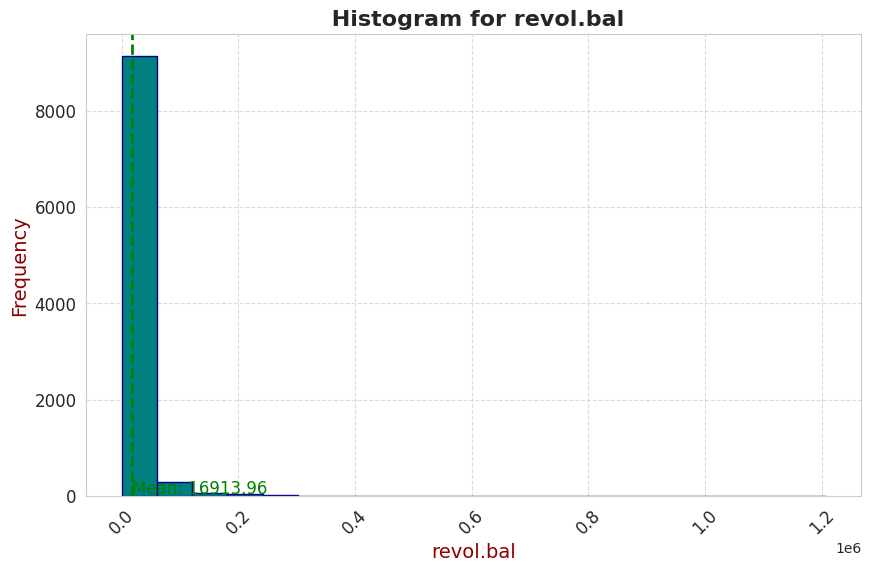

In [61]:
# 
col = df.select_dtypes(include=['int', 'float']).columns[6]

# Plot histogram for the first numerical column with improvements
plt.figure(figsize=(10, 6))

# Use a more appealing color palette and adjust the edge color
plt.hist(df[col], bins=20, color='teal', edgecolor='darkblue')

# Add title with custom font size and weight
plt.title(f' Histogram for {col}', fontsize=16, fontweight='bold')

# Label x and y axes with increased font size and a different color
plt.xlabel(col, fontsize=14, color='darkred')
plt.ylabel('Frequency', fontsize=14, color='darkred')

# Adjust the x-axis and y-axis ticks for better readability
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

# Add a grid for better readability of bars and set the grid style
plt.grid(True, linestyle='--', alpha=0.7)

# Add a vertical line for mean or median (optional)
mean_value = df[col].mean()
plt.axvline(mean_value, color='green', linestyle='dashed', linewidth=2)
plt.text(mean_value + 0.1, 50, f'Mean: {mean_value:.2f}', color='green', fontsize=12)

# Display the plot
plt.show()


***Purpose of the Chart***:
- The histogram visualizes the distribution of the `revol.bal` feature, which represents the total revolving credit balance of borrowers. This is the amount of credit the borrower is currently using from revolving credit accounts (e.g., credit cards).

***Key Observations***:
- **Mean Revolving Balance**: The mean revolving balance is **6913.96**, indicating that, on average, borrowers have a revolving credit balance of approximately **6,914**.
- **Frequency Distribution**:
  - The histogram likely shows a right-skewed distribution, with most borrowers having lower revolving balances (e.g., below **10,000**).
  - There are fewer borrowers with very high revolving balances (e.g., above **20,000**), as indicated by the tapering tail of the histogram.

***Insights***:
1. **Typical Borrower Revolving Balance**:
   - Most borrowers have revolving balances below **10,000**, suggesting that they are not heavily utilizing their available revolving credit.
   - Borrowers with very high revolving balances (e.g., above **20,000**) are less common, as indicated by the tapering tail of the histogram.

2. **Implications for Loan Default**:
   - Borrowers with higher revolving balances (e.g., above **10,000**) might be at greater risk of default, as they are using a larger portion of their available credit, which could indicate financial stress.
   - Borrowers with lower revolving balances (e.g., below **5,000**) are likely at lower risk of default, as they have more available credit and better financial flexibility.

3. **Outliers and Skewness**:
   - The right-skewed distribution indicates that while most borrowers have moderate to low revolving balances, there are some outliers with extremely high revolving balances.
   - These outliers might represent borrowers who are heavily reliant on revolving credit, which could be a red flag for financial instability.

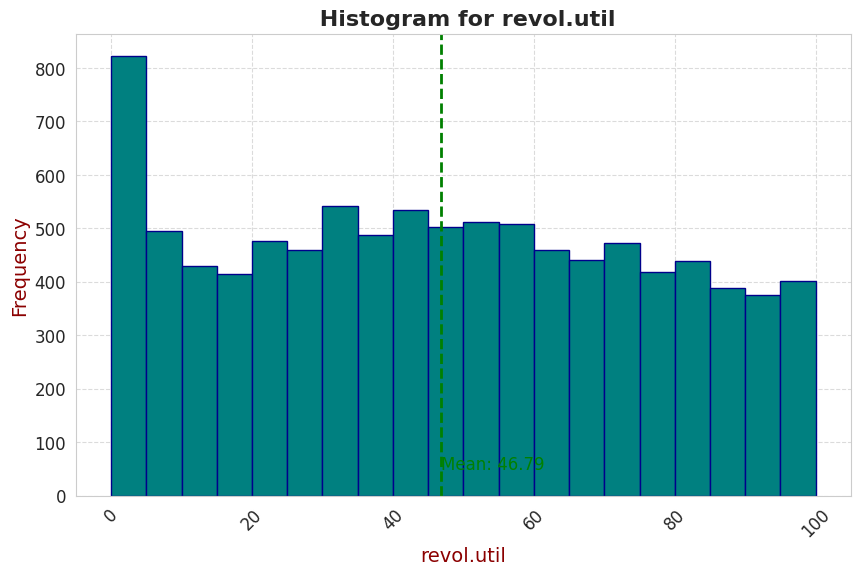

In [62]:
# 
col = df.select_dtypes(include=['int', 'float']).columns[7]

# Plot histogram for the first numerical column with improvements
plt.figure(figsize=(10, 6))

# Use a more appealing color palette and adjust the edge color
plt.hist(df[col], bins=20, color='teal', edgecolor='darkblue')

# Add title with custom font size and weight
plt.title(f' Histogram for {col}', fontsize=16, fontweight='bold')

# Label x and y axes with increased font size and a different color
plt.xlabel(col, fontsize=14, color='darkred')
plt.ylabel('Frequency', fontsize=14, color='darkred')

# Adjust the x-axis and y-axis ticks for better readability
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

# Add a grid for better readability of bars and set the grid style
plt.grid(True, linestyle='--', alpha=0.7)

# Add a vertical line for mean or median (optional)
mean_value = df[col].mean()
plt.axvline(mean_value, color='green', linestyle='dashed', linewidth=2)
plt.text(mean_value + 0.1, 50, f'Mean: {mean_value:.2f}', color='green', fontsize=12)

# Display the plot
plt.show()


***Purpose of the Chart***:
- The histogram visualizes the distribution of the `revol.util` feature, which represents the **revolving utilization rate**. This is the percentage of a borrower's available revolving credit (e.g., credit cards) that is currently being used.

***Key Observations***:
- **Mean Revolving Utilization**: The mean revolving utilization rate is **46.79%**, indicating that, on average, borrowers are using nearly half of their available revolving credit.
- **Frequency Distribution**:
  - The histogram likely shows a right-skewed distribution, with most borrowers having lower revolving utilization rates (e.g., below **50%**).
  - There are fewer borrowers with very high utilization rates (e.g., above **80%**), as indicated by the tapering tail of the histogram.

***Insights***:
1. **Typical Borrower Credit Usage**:
   - Most borrowers have revolving utilization rates below **50%**, suggesting that they are not maxing out their available credit.
   - Borrowers with very high utilization rates (e.g., above **80%**) are less common, as indicated by the tapering tail of the histogram.

2. **Implications for Loan Default**:
   - Borrowers with higher revolving utilization rates (e.g., above **50%**) might be at greater risk of default, as they are using a larger portion of their available credit, which could indicate financial stress.
   - Borrowers with lower utilization rates (e.g., below **30%**) are likely at lower risk of default, as they have more available credit and better financial flexibility.

3. **Outliers and Skewness**:
   - The right-skewed distribution indicates that while most borrowers have moderate to low utilization rates, there are some outliers with extremely high utilization rates.
   - These outliers might represent borrowers who are heavily reliant on revolving credit, which could be a red flag for financial instability.

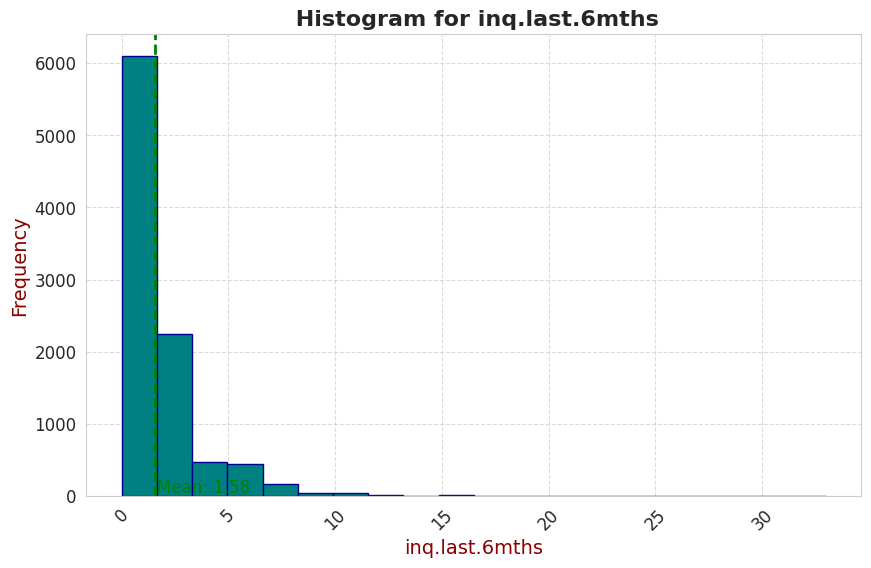

In [63]:
# 
col = df.select_dtypes(include=['int', 'float']).columns[8]

# Plot histogram for the first numerical column with improvements
plt.figure(figsize=(10, 6))

# Use a more appealing color palette and adjust the edge color
plt.hist(df[col], bins=20, color='teal', edgecolor='darkblue')

# Add title with custom font size and weight
plt.title(f' Histogram for {col}', fontsize=16, fontweight='bold')

# Label x and y axes with increased font size and a different color
plt.xlabel(col, fontsize=14, color='darkred')
plt.ylabel('Frequency', fontsize=14, color='darkred')

# Adjust the x-axis and y-axis ticks for better readability
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

# Add a grid for better readability of bars and set the grid style
plt.grid(True, linestyle='--', alpha=0.7)

# Add a vertical line for mean or median (optional)
mean_value = df[col].mean()
plt.axvline(mean_value, color='green', linestyle='dashed', linewidth=2)
plt.text(mean_value + 0.1, 50, f'Mean: {mean_value:.2f}', color='green', fontsize=12)

# Display the plot
plt.show()


***Purpose of the Chart***:
- The histogram visualizes the distribution of the `inq.last.6mths` feature, which represents the number of credit inquiries made in the last 6 months. This indicates how frequently a borrower has applied for new credit.

***Key Observations***:
- **Mean Inquiries**: The mean number of inquiries is **1.58**, indicating that, on average, borrowers have made approximately **1.58 credit inquiries** in the last 6 months.
- **Median Inquiries**: The median is **0**, meaning that at least half of the borrowers have made **no credit inquiries** in the last 6 months.
- **Frequency Distribution**:
  - The histogram likely shows a right-skewed distribution, with most borrowers having **0 or 1 inquiry**.
  - Borrowers with higher numbers of inquiries (e.g., **3 or more**) are less common, as indicated by the tapering tail of the histogram.

***Insights***:
1. **Typical Borrower Credit-Seeking Behavior**:
   - Most borrowers have made **0 or 1 credit inquiry** in the last 6 months, suggesting that they are not actively seeking new credit frequently.
   - Borrowers with **2 or more inquiries** are less common, indicating that frequent credit-seeking behavior is rare.

2. **Implications for Loan Default**:
   - Borrowers with higher numbers of inquiries (e.g., **3 or more**) might be at greater risk of default, as frequent credit-seeking behavior could indicate financial stress or a higher reliance on credit.
   - Borrowers with **0 or 1 inquiry** are likely at lower risk of default, as they are not actively seeking new credit and may have more stable financial situations.

3. **Outliers and Skewness**:
   - The right-skewed distribution indicates that while most borrowers have few or no inquiries, there are some outliers with many inquiries.
   - Borrowers with **4 or more inquiries** might represent outliers who are actively seeking credit, which could be a red flag for financial instability.

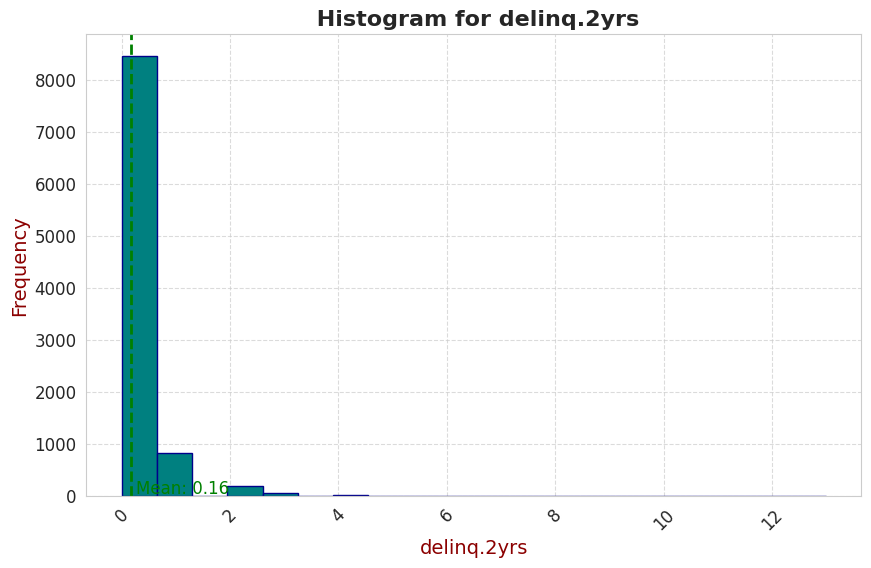

In [64]:
# 
col = df.select_dtypes(include=['int', 'float']).columns[9]

# Plot histogram for the first numerical column with improvements
plt.figure(figsize=(10, 6))

# Use a more appealing color palette and adjust the edge color
plt.hist(df[col], bins=20, color='teal', edgecolor='darkblue')

# Add title with custom font size and weight
plt.title(f' Histogram for {col}', fontsize=16, fontweight='bold')

# Label x and y axes with increased font size and a different color
plt.xlabel(col, fontsize=14, color='darkred')
plt.ylabel('Frequency', fontsize=14, color='darkred')

# Adjust the x-axis and y-axis ticks for better readability
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

# Add a grid for better readability of bars and set the grid style
plt.grid(True, linestyle='--', alpha=0.7)

# Add a vertical line for mean or median (optional)
mean_value = df[col].mean()
plt.axvline(mean_value, color='green', linestyle='dashed', linewidth=2)
plt.text(mean_value + 0.1, 50, f'Mean: {mean_value:.2f}', color='green', fontsize=12)

# Display the plot
plt.show()


***Purpose of the Chart***:
- The histogram visualizes the distribution of the `delinq.2yrs` feature, which represents the number of delinquencies (missed payments) a borrower has had in the last 2 years. This is a key indicator of credit risk.

***Key Observations***:
- **Mean Delinquencies**: The mean number of delinquencies is **0.16**, indicating that, on average, borrowers have had **0.16 delinquencies** in the last 2 years.
- **Frequency Distribution**:
  - The histogram likely shows a highly right-skewed distribution, with most borrowers having **0 delinquencies**.
  - Borrowers with **1 or more delinquencies** are less common, as indicated by the tapering tail of the histogram.

***Insights***:
1. **Typical Borrower Credit Behavior**:
   - The vast majority of borrowers have **0 delinquencies**, suggesting that most borrowers have a clean payment history and are managing their debts responsibly.
   - Borrowers with **1 or more delinquencies** are relatively rare, indicating that missed payments are uncommon in this dataset.

2. **Implications for Loan Default**:
   - Borrowers with **1 or more delinquencies** might be at greater risk of default, as missed payments in the past could indicate financial instability or poor credit management.
   - Borrowers with **0 delinquencies** are likely at lower risk of default, as they have a history of timely payments and better credit behavior.

3. **Outliers and Skewness**:
   - The highly right-skewed distribution indicates that while most borrowers have no delinquencies, there are a few outliers with **1 or more delinquencies**.
   - These outliers might represent borrowers who are at higher risk of default due to their history of missed payments.

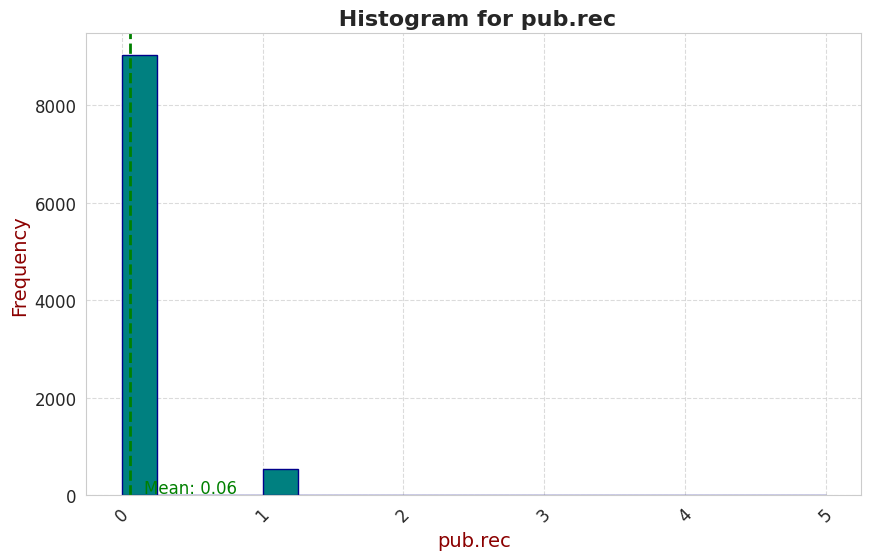

In [65]:
# 
col = df.select_dtypes(include=['int', 'float']).columns[10]

# Plot histogram for the first numerical column with improvements
plt.figure(figsize=(10, 6))

# Use a more appealing color palette and adjust the edge color
plt.hist(df[col], bins=20, color='teal', edgecolor='darkblue')

# Add title with custom font size and weight
plt.title(f' Histogram for {col}', fontsize=16, fontweight='bold')

# Label x and y axes with increased font size and a different color
plt.xlabel(col, fontsize=14, color='darkred')
plt.ylabel('Frequency', fontsize=14, color='darkred')

# Adjust the x-axis and y-axis ticks for better readability
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

# Add a grid for better readability of bars and set the grid style
plt.grid(True, linestyle='--', alpha=0.7)

# Add a vertical line for mean or median (optional)
mean_value = df[col].mean()
plt.axvline(mean_value, color='green', linestyle='dashed', linewidth=2)
plt.text(mean_value + 0.1, 50, f'Mean: {mean_value:.2f}', color='green', fontsize=12)

# Display the plot
plt.show()


***Purpose of the Chart***:
- The histogram visualizes the distribution of the `pub.rec` feature, which represents the number of derogatory public records (e.g., bankruptcies, tax liens, or judgments) associated with the borrower. This is a key indicator of credit risk.

***Key Observations***:
- **Mean Public Records**: The mean number of derogatory public records is **0.06**, indicating that, on average, borrowers have **0.06 derogatory public records**.
- **Frequency Distribution**:
  - The histogram likely shows a highly right-skewed distribution, with most borrowers having **0 derogatory public records**.
  - Borrowers with **1 or more derogatory public records** are rare, as indicated by the tapering tail of the histogram.

***Insights***:
1. **Typical Borrower Credit History**:
   - The vast majority of borrowers have **0 derogatory public records**, suggesting that most borrowers have a clean credit history with no significant negative public records.
   - Borrowers with **1 or more derogatory public records** are relatively rare, indicating that such negative records are uncommon in this dataset.

2. **Implications for Loan Default**:
   - Borrowers with **1 or more derogatory public records** might be at greater risk of default, as these records indicate past financial difficulties or legal issues.
   - Borrowers with **0 derogatory public records** are likely at lower risk of default, as they have no significant negative marks on their credit history.

3. **Outliers and Skewness**:
   - The highly right-skewed distribution indicates that while most borrowers have no derogatory public records, there are a few outliers with **1 or more records**.
   - These outliers might represent borrowers who are at higher risk of default due to their history of financial or legal issues.

***Logarithmic Transformation of the revol.bal Feature***

In many datasets, numerical features may have skewed distributions with long tails. Applying a logarithmic transformation can help in reducing skewness, making the data more normally distributed and improving the performance of machine learning models.

In this section, we apply a logarithmic transformation to the revol.bal feature. To avoid taking the log of zero, we add 1 to the values before applying the log transformation. This transformation is helpful when the values of revol.bal span a wide range.

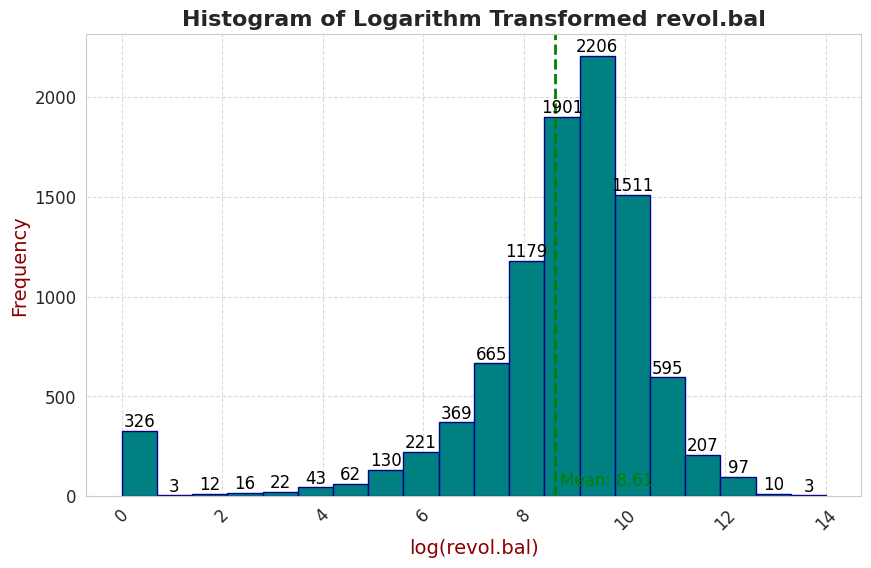

In [68]:
# Apply logarithm transformation to 'revol.bal'
df['log_revol_bal'] = np.log(df['revol.bal'] + 1)  # Adding 1 to avoid log(0)

# Plot histogram for the transformed feature
plt.figure(figsize=(10, 6))

# Use the desired color palette and adjust the edge color
n, bins, patches = plt.hist(df['log_revol_bal'], bins=20, color='teal', edgecolor='darkblue')

# Add title with custom font size and weight
plt.title('Histogram of Logarithm Transformed revol.bal', fontsize=16, fontweight='bold')

# Label x and y axes with increased font size and a different color
plt.xlabel('log(revol.bal)', fontsize=14, color='darkred')
plt.ylabel('Frequency', fontsize=14, color='darkred')

# Adjust the x-axis and y-axis ticks for better readability
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

# Add a grid for better readability of bars and set the grid style
plt.grid(True, linestyle='--', alpha=0.7)

# Add count labels above each bar
for patch, count in zip(patches, n):
    height = patch.get_height()
    plt.text(patch.get_x() + patch.get_width() / 2, height + 0.5, f'{int(count)}', 
             ha='center', va='bottom', fontsize=12, color='black')

# Add a vertical line for mean value
mean_value = df['log_revol_bal'].mean()
plt.axvline(mean_value, color='green', linestyle='dashed', linewidth=2)
plt.text(mean_value + 0.1, 50, f'Mean: {mean_value:.2f}', color='green', fontsize=12)

# Show the plot
plt.show()


***Purpose of the Chart***:
- The histogram visualizes the distribution of the logarithmically transformed `revol.bal` feature, which represents the total revolving credit balance of borrowers. The log transformation is used to normalize the data and reduce skewness.

***Key Observations***:
- **Mean Log Revolving Balance**: The mean log-transformed revolving balance is **8.61**, which, when exponentiated (e^8.61), translates to approximately **5,500** (assuming natural log). This provides a central tendency measure for the distribution.
- **Frequency Distribution**:
  - The histogram shows a more symmetric or bell-shaped distribution after the log transformation, indicating that the transformation has reduced the skewness of the original data.
  - The majority of borrowers fall within a specific range of log revolving balances, with frequencies tapering off on both ends (lower and higher balances).

***Insights***:
1. **Typical Borrower Revolving Balance**:
   - Most borrowers have log revolving balances clustered around the mean (**8.61**), indicating that the majority of borrowers have revolving balances close to the median range.
   - Borrowers with extremely high or low log revolving balances are less common, as indicated by the tapering ends of the histogram.

2. **Implications for Loan Default**:
   - Borrowers with higher log revolving balances (e.g., above **8.61**) might be at greater risk of default, as they have larger outstanding revolving credit, which could indicate financial stress.
   - Borrowers with lower log revolving balances (e.g., below **8.61**) might be at lower risk of default, as they have smaller outstanding revolving credit and potentially better financial flexibility.

3. **Outliers and Skewness**:
   - The bell-shaped distribution suggests that the dataset is well-represented across a range of revolving balances, with no extreme skewness.
   - The concentration of balances around the mean indicates that the majority of borrowers have similar levels of revolving credit usage.

#### ***Correlation Analysis between Numerical Features***

Understanding the relationships between features is a crucial step in feature engineering and model building. Correlation analysis helps us identify patterns and dependencies among numerical features, which can guide the selection of features or transformation methods.

In this section, we calculate the Spearman correlation coefficient for the numerical features in our dataset. Spearman correlation is a non-parametric measure of rank correlation that evaluates how well the relationship between two variables can be described using a monotonic function.

Steps Involved:
- Correlation Matrix: We compute the Spearman correlation matrix for the numerical features.
- Spearman Correlation Test: For each pair of numerical columns, we compute the Spearman correlation coefficient and the associated p-value to assess the statistical significance of the correlation.
- Heatmap Visualization: We visualize the correlation matrix as a heatmap for better insight into the relationships between variables.

In [28]:
# Selecting numerical columns for correlation analysis
numerical_columns = df.select_dtypes(include=['int', 'float']).columns

# Calculating correlation matrix
correlation_matrix = df[numerical_columns].corr(method='spearman')

# Displaying correlation matrix
print("Correlation Matrix between numerical features:")
print(correlation_matrix)

# Running Spearman correlation test
print("\nSpearman Correlation Statistical Test:")
for col1 in numerical_columns:
    for col2 in numerical_columns:
        if col1 != col2:
            corr, p_value = spearmanr(df[col1], df[col2])
            print(f"{col1} vs {col2}: Spearman correlation coefficient = {corr}, p-value = {p_value}")

Correlation Matrix between numerical features:
                   int.rate  installment  log.annual.inc       dti      fico  \
int.rate           1.000000     0.242914        0.041648  0.216114 -0.744986   
installment        0.242914     1.000000        0.431405  0.062547  0.085257   
log.annual.inc     0.041648     0.431405        1.000000 -0.059672  0.107878   
dti                0.216114     0.062547       -0.059672  1.000000 -0.214496   
fico              -0.744986     0.085257        0.107878 -0.214496  1.000000   
days.with.cr.line -0.133584     0.201920        0.400251  0.072858  0.251729   
revol.bal          0.148719     0.351844        0.415817  0.375950 -0.094562   
revol.util         0.472965     0.096014        0.053173  0.333658 -0.520085   
inq.last.6mths     0.174137    -0.006740        0.030574  0.028044 -0.173743   
delinq.2yrs        0.172677    -0.007541        0.029732 -0.018420 -0.237059   
pub.rec            0.093887    -0.027854        0.013282  0.009311 -0.148

- Numerical Columns Selection: We first identify the numerical columns (int and float) in the dataset using df.select_dtypes().

- Spearman Correlation Matrix: Using the corr() function with the method set to spearman, we calculate the correlation matrix for the selected numerical columns. This matrix shows the correlation between each pair of numerical features.

- Spearman Correlation Test:

  - We iterate over each pair of numerical columns.
  - For each pair, we calculate the Spearman correlation coefficient and the p-value using the spearmanr() function from the scipy.stats module.
  - The correlation coefficient quantifies the strength and direction of the monotonic relationship, while the p-value tests the null hypothesis that there is no correlation between the variables.


- Correlation Heatmap:

  - The sns.heatmap() function is used to create a heatmap of the correlation matrix.
  - The color scale helps identify stronger positive and negative correlations.
  - We use the annot=True parameter to display the correlation coefficients in the heatmap.

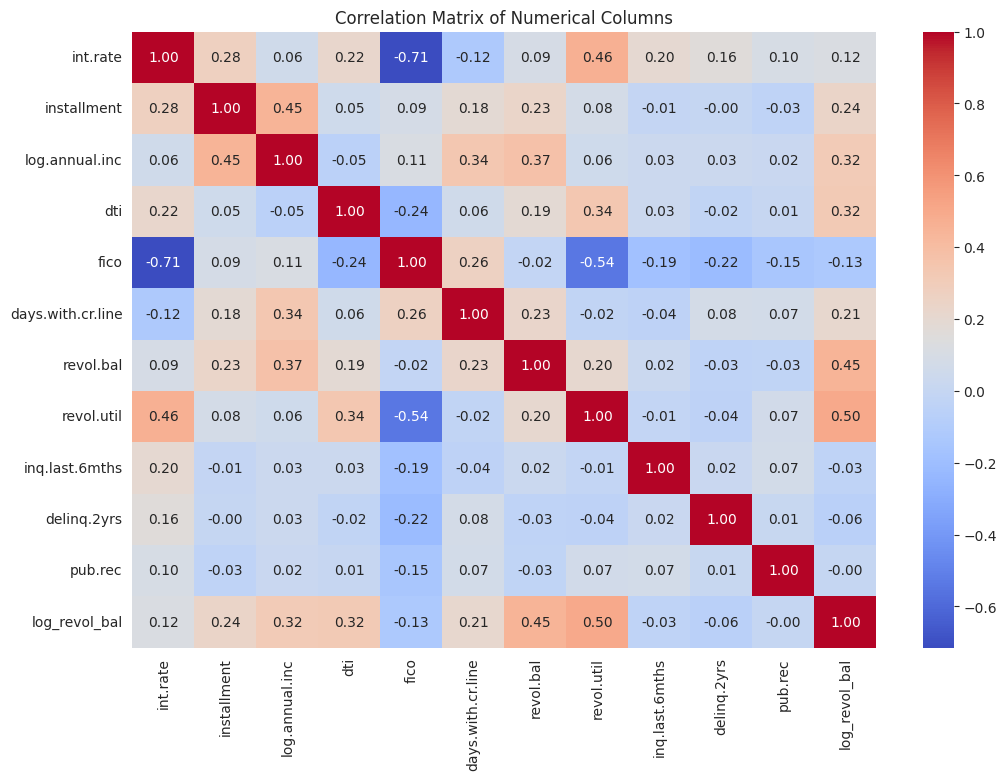

In [29]:
# Calculate the correlation matrix for numerical columns
correlation_matrix = df[numerical_columns].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Columns')
plt.show()


***Purpose of the Chart***:
- The correlation matrix visualizes the pairwise correlations between numerical features in the dataset. Correlation values range from **-1 to 1**, where:
  - **1** indicates a perfect positive correlation,
  - **-1** indicates a perfect negative correlation,
  - **0** indicates no correlation.

***Key Observations***:
1. **Strong Positive Correlations**:
   - **`int.rate` and `fico`**: **-0.71** (strong negative correlation)  
     - Higher FICO scores are associated with lower interest rates, as borrowers with better credit scores are considered less risky.
   - **`revol.util` and `int.rate`**: **0.46**  
     - Higher revolving credit utilization is associated with higher interest rates, possibly because borrowers using more of their available credit are seen as riskier.
   - **`log_revol_bal` and `revol.util`**: **0.50**  
     - Higher revolving balances are associated with higher utilization rates, which is expected since both are related to credit usage.

2. **Moderate Positive Correlations**:
   - **`installment` and `log.annual.inc`**: **0.45**  
     - Borrowers with higher incomes tend to have higher installment payments, likely because they qualify for larger loans.
   - **`log_revol_bal` and `revol.bal`**: **0.45**  
     - This is expected since `log_revol_bal` is a transformation of `revol.bal`.
   - **`days.with.cr.line` and `log.annual.inc`**: **0.34**  
     - Borrowers with longer credit histories tend to have higher incomes.

3. **Strong Negative Correlations**:
   - **`fico` and `int.rate`**: **-0.71**  
     - As mentioned earlier, higher FICO scores are associated with lower interest rates.
   - **`fico` and `revol.util`**: **-0.54**  
     - Borrowers with higher FICO scores tend to have lower revolving credit utilization, indicating better credit management.

4. **Weak or No Correlations**:
   - **`pub.rec` and most features**: Close to **0**  
     - Derogatory public records show little to no correlation with other features, suggesting they are relatively independent.
   - **`delinq.2yrs` and most features**: Close to **0**  
     - Delinquencies in the last 2 years also show little correlation with other features.

***Insights***:
1. **Interest Rate (`int.rate`)**:
   - Strongly influenced by **FICO score** and **revolving utilization**, with higher FICO scores leading to lower rates and higher utilization leading to higher rates.

2. **FICO Score (`fico`)**:
   - A key feature with strong negative correlations to **interest rates** and **revolving utilization**, indicating its importance in determining credit risk.

3. **Revolving Credit Usage (`revol.util` and `revol.bal`)**:
   - Both features are moderately correlated with each other and with **interest rates**, suggesting that higher credit usage is associated with higher risk.

4. **Income and Credit History**:
   - **Log annual income** and **days with credit line** show moderate positive correlations, indicating that borrowers with longer credit histories tend to have higher incomes.

5. **Derogatory Records and Delinquencies**:
   - Features like **`pub.rec`** and **`delinq.2yrs`** show weak correlations with other features, suggesting they may have limited direct influence on other variables but could still be important for predicting loan defaults.

## **6. Feature Engineering**

#### **6.1 One-Hot Encoding of Features**

One-hot encoding is a method used to convert categorical variables into a format that can be provided to machine learning algorithms to improve their performance. This transformation creates new binary columns (0 or 1) for each category within the categorical feature, where 1 indicates the presence of a category and 0 indicates its absence.

In this section, we perform one-hot encoding on the purpose column to transform it into multiple binary columns, representing different loan purposes. We then integrate these new columns into our dataset and drop the original categorical purpose column.

Steps Involved:
- One-Hot Encoding: We use pd.get_dummies() to convert the purpose column into binary variables (dummy variables).
- Data Type Conversion: We convert the newly created dummy variables to boolean data types for consistency.
- Concatenation: We concatenate these dummy variables with the original DataFrame.
- Dropping the Original Column: The original categorical column purpose is no longer necessary and is dropped from the DataFrame.

In [30]:
# Perform one-hot encoding for 'purpose'
one_hot_encoded = pd.get_dummies(df['purpose'], prefix='purpose')

# Convert dummy variables to boolean data type
one_hot_encoded = one_hot_encoded.astype(bool)

# Add the one-hot encoded variables to the dataset
df = pd.concat([df, one_hot_encoded], axis=1)

# Drop the original 'purpose' column
df.drop('purpose', axis=1, inplace=True)

# Display the updated DataFrame
print(df.head())


   credit.policy  int.rate  installment  log.annual.inc    dti  fico  \
0           True    0.1189       829.10       11.350407  19.48   737   
1           True    0.1071       228.22       11.082143  14.29   707   
2           True    0.1357       366.86       10.373491  11.63   682   
3           True    0.1008       162.34       11.350407   8.10   712   
4           True    0.1426       102.92       11.299732  14.97   667   

   days.with.cr.line  revol.bal  revol.util  inq.last.6mths  ...  delinq_bins  \
0        5639.958333      28854        52.1               0  ...         bin1   
1        2760.000000      33623        76.7               0  ...         bin1   
2        4710.000000       3511        25.6               1  ...         bin1   
3        2699.958333      33667        73.2               1  ...         bin1   
4        4066.000000       4740        39.5               0  ...         bin2   

   pub_rec_bins  log_revol_bal purpose_all_other purpose_credit_card  \
0       

- One-Hot Encoding: We apply pd.get_dummies(df['purpose'], prefix='purpose') to the purpose column. This creates a binary column for each possible loan purpose (e.g., 'purpose_car', 'purpose_education').

- Data Type Conversion: By calling .astype(bool), we ensure that the dummy variables are boolean values (True or False). This step ensures data consistency when working with categorical features in machine learning models.

- Concatenating New Variables: We add the new binary columns to the original dataset using pd.concat(). This step appends the one-hot encoded columns as additional features in the dataset.

- Dropping the Original Column: The original purpose column is no longer needed, as we have created separate binary columns for each category. Therefore, we use df.drop('purpose', axis=1, inplace=True) to remove it.



In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   credit.policy               9578 non-null   bool   
 1   int.rate                    9578 non-null   float64
 2   installment                 9578 non-null   float64
 3   log.annual.inc              9578 non-null   float64
 4   dti                         9578 non-null   float64
 5   fico                        9578 non-null   int64  
 6   days.with.cr.line           9578 non-null   float64
 7   revol.bal                   9578 non-null   int64  
 8   revol.util                  9578 non-null   float64
 9   inq.last.6mths              9578 non-null   int64  
 10  delinq.2yrs                 9578 non-null   int64  
 11  pub.rec                     9578 non-null   int64  
 12  not.fully.paid              9578 non-null   bool   
 13  inq_bins                    9578 

In [32]:
# Drop the 'revol.bal' feature from the DataFrame
df.drop(['revol.bal', 'inq.last.6mths','delinq.2yrs', 'pub.rec'], axis=1, inplace=True)

# Display the updated DataFrame
print(df.head())

   credit.policy  int.rate  installment  log.annual.inc    dti  fico  \
0           True    0.1189       829.10       11.350407  19.48   737   
1           True    0.1071       228.22       11.082143  14.29   707   
2           True    0.1357       366.86       10.373491  11.63   682   
3           True    0.1008       162.34       11.350407   8.10   712   
4           True    0.1426       102.92       11.299732  14.97   667   

   days.with.cr.line  revol.util  not.fully.paid inq_bins delinq_bins  \
0        5639.958333        52.1           False     bin1        bin1   
1        2760.000000        76.7           False     bin1        bin1   
2        4710.000000        25.6           False     bin2        bin1   
3        2699.958333        73.2           False     bin2        bin1   
4        4066.000000        39.5           False     bin1        bin2   

  pub_rec_bins  log_revol_bal  purpose_all_other  purpose_credit_card  \
0         bin1      10.270039              False       

#### ***6.2 Label Encoding of Categorical Features***

Label encoding is a technique used to convert categorical variables into numerical values, where each unique category is assigned a specific integer value. This method is typically used when the categorical variable has an ordinal relationship, i.e., the categories have a meaningful order.

In this section, we apply label encoding to the following columns:

- inq_bins
- delinq_bins
- pub_rec_bins

This transformation helps us convert the categorical labels in these columns into integer labels that can be used in machine learning algorithms.

Steps Involved:
- Label Encoding: We use LabelEncoder from sklearn.preprocessing to encode the categorical features into integer labels.
- Updating DataFrame: The encoded labels replace the original categorical columns in the DataFrame.

In [33]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to the specified features
df['inq_bins'] = label_encoder.fit_transform(df['inq_bins'])
df['delinq_bins'] = label_encoder.fit_transform(df['delinq_bins'])
df['pub_rec_bins'] = label_encoder.fit_transform(df['pub_rec_bins'])

# Display the updated DataFrame
print(df.head())


   credit.policy  int.rate  installment  log.annual.inc    dti  fico  \
0           True    0.1189       829.10       11.350407  19.48   737   
1           True    0.1071       228.22       11.082143  14.29   707   
2           True    0.1357       366.86       10.373491  11.63   682   
3           True    0.1008       162.34       11.350407   8.10   712   
4           True    0.1426       102.92       11.299732  14.97   667   

   days.with.cr.line  revol.util  not.fully.paid  inq_bins  delinq_bins  \
0        5639.958333        52.1           False         0            0   
1        2760.000000        76.7           False         0            0   
2        4710.000000        25.6           False         1            0   
3        2699.958333        73.2           False         1            0   
4        4066.000000        39.5           False         0            1   

   pub_rec_bins  log_revol_bal  purpose_all_other  purpose_credit_card  \
0             0      10.270039            

#### ***6.3 Splitting the Data into Training and Testing Sets***

Splitting the data into training and testing sets is an essential step in building machine learning models. The training set is used to train the model, while the testing set is used to evaluate the model's performance on unseen data.

In this section, we perform the following steps:

- Separate Features (X) and Target (y): The target variable (not.fully.paid) is separated from the feature variables, which are stored in X.
- Split the Data: We use train_test_split() from sklearn.model_selection to randomly split the data into training and testing sets. The dataset is split with an 80% training and 20% testing ratio. Additionally, we use stratification to ensure that the distribution of the target variable is similar in both training and testing sets.
- Display the Shapes: We print the shapes of the training and testing sets to confirm the proper split.

In [34]:
# Separate features (X) and target (y)
X = df.drop('not.fully.paid', axis=1)
y = df['not.fully.paid']

# Split the data into train and test sets (80% train, 20% test), stratified by 'not.fully.paid'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Display the shapes of the train and test sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (7662, 19)
Shape of X_test: (1916, 19)
Shape of y_train: (7662,)
Shape of y_test: (1916,)


#### ***6.5 Standardizing the Features***

Standardization (or Z-score normalization) is a crucial preprocessing step when working with machine learning models, especially those that are sensitive to the scale of the features (e.g., linear models, support vector machines, and neural networks). The goal of standardization is to scale the features so that they have a mean of 0 and a standard deviation of 1.

In this section, we perform the following steps:

- Identify Numerical Columns: We identify the columns in the training set (X_train) that are of numerical type (int64 or float64).
- Initialize StandardScaler: We use the StandardScaler from sklearn.preprocessing to scale the numerical features.
- Fit and Transform the Training Data: We fit the scaler on the training data and transform it, scaling the numerical features to have zero mean and unit variance.
- Transform the Test Data: We use the same scaler that was fitted on the training set to transform the test data. This ensures that the model sees the test data on the same scale as the training data.

In [35]:
# Identify numerical columns in the training set
numerical_columns = [col for col in X_train.columns if X_train[col].dtype in ['int64', 'float64']]

# Initialize StandardScaler
scaler = StandardScaler()

# Fit scaler on the training data and transform it
X_train_scaled = X_train.copy()  # Make a copy to avoid modifying the original DataFrame
X_train_scaled[numerical_columns] = scaler.fit_transform(X_train_scaled[numerical_columns])

# Apply the same scaler to the numerical features in the test set
X_test_scaled = X_test.copy()  # Make a copy to avoid modifying the original DataFrame
X_test_scaled[numerical_columns] = scaler.transform(X_test_scaled[numerical_columns])


In [36]:
X_train_scaled.head()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.util,inq_bins,delinq_bins,pub_rec_bins,log_revol_bal,purpose_all_other,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
6381,True,0.744534,1.109194,0.696658,0.012171,-0.629324,0.275685,0.952688,0.130142,2.009714,-0.252142,0.510377,False,True,False,False,False,False,False
7589,True,-1.779946,-0.795226,0.174696,0.017975,0.689102,0.234302,-0.150510,-1.034752,-0.340474,-0.252142,0.346771,False,True,False,False,False,False,False
465,True,-0.912273,-0.889878,-0.252212,-0.101001,0.161732,0.699294,-0.339532,-1.034752,2.009714,-0.252142,0.583595,False,False,True,False,False,False,False
5343,True,0.486476,0.096296,1.097154,0.506940,-0.629324,-0.493588,0.086626,0.130142,-0.340474,-0.252142,-0.571997,True,False,False,False,False,False,False
8016,False,0.318178,0.576044,1.172312,-0.333151,-1.288536,-1.555593,-1.614567,1.295036,-0.340474,-0.252142,-3.950224,False,False,True,False,False,False,False


In [37]:
X_test_scaled.head()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.util,inq_bins,delinq_bins,pub_rec_bins,log_revol_bal,purpose_all_other,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
8157,False,1.212031,0.480230,0.164232,0.399571,-1.684064,-1.078288,0.794597,-1.034752,-0.340474,-0.252142,0.325094,False,False,True,False,False,False,False
1928,True,-1.596687,-1.263839,-0.185788,0.933514,0.557259,0.080371,-0.040534,-1.034752,-0.340474,-0.252142,0.741887,False,False,True,False,False,False,False
2779,True,0.568756,1.751231,1.477852,-0.798900,0.029889,0.210437,-0.745069,-1.034752,-0.340474,-0.252142,0.148504,True,False,False,False,False,False,False
2520,True,0.213459,-1.234983,-2.144838,-0.311387,-0.233796,-0.894542,-1.487408,0.130142,-0.340474,-0.252142,-0.977857,True,False,False,False,False,False,False
2601,True,1.275610,0.146309,0.027415,-0.726354,-0.761166,-0.684511,-0.439198,0.130142,-0.340474,-0.252142,-0.509620,False,False,False,False,True,False,False


## **7. Model Building and Training**

In this section, we initialize and evaluate three different machine learning models on the scaled training data. We perform cross-validation, fit the models, and evaluate their performance on the test set. The models being compared are:

1. Logistic Regression: A linear model used for binary classification.
2. Random Forest Classifier: An ensemble method based on decision trees that improves accuracy by averaging multiple trees.
3. Gradient Boosting Machine (GBM): Another powerful ensemble method that builds trees sequentially, with each tree correcting the errors of the previous one.


Here's a breakdown of the process:

- Cross-Validation:

  - We use 5-fold cross-validation to estimate the performance of each model.
  - This technique splits the data into 5 subsets and trains the model on 4 subsets while testing it on the remaining subset.
  - The cross-validation scores help ensure that the model generalizes well and is not overfitting to the training data.

- Model Fitting:

  - After evaluating each model with cross-validation, we train the model on the entire training set (X_train_scaled) and evaluate it on the test set.

- Model Evaluation:

  - After fitting the model, we make predictions on the test set (X_test_scaled).
  - We then evaluate the performance using metrics like accuracy, precision, recall, and F1-score through the classification report.

In [38]:
# Initialize models
log_reg = LogisticRegression()
rf_classifier = RandomForestClassifier()
gbm_classifier = GradientBoostingClassifier()

# List of models
models = [log_reg, rf_classifier, gbm_classifier]
model_names = ['Logistic Regression', 'Random Forest', 'Gradient Boosting Machine']

# Iterate over models
for model, name in zip(models, model_names):
    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    print(f"{name} Cross-Validation Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    # Fit the model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Evaluate the model
    print(f"{name} Classification Report:")
    print(classification_report(y_test, y_pred))

Logistic Regression Cross-Validation Accuracy: 0.8406 (+/- 0.0020)
Logistic Regression Classification Report:
              precision    recall  f1-score   support

       False       0.84      1.00      0.91      1609
        True       0.64      0.02      0.04       307

    accuracy                           0.84      1916
   macro avg       0.74      0.51      0.48      1916
weighted avg       0.81      0.84      0.77      1916

Random Forest Cross-Validation Accuracy: 0.8380 (+/- 0.0044)
Random Forest Classification Report:
              precision    recall  f1-score   support

       False       0.84      0.99      0.91      1609
        True       0.29      0.01      0.02       307

    accuracy                           0.84      1916
   macro avg       0.56      0.50      0.47      1916
weighted avg       0.75      0.84      0.77      1916

Gradient Boosting Machine Cross-Validation Accuracy: 0.8384 (+/- 0.0033)
Gradient Boosting Machine Classification Report:
              pr

1) Initialize Models:

- log_reg = LogisticRegression(): Logistic Regression model is initialized.
- rf_classifier = RandomForestClassifier(): Random Forest Classifier is initialized.
- gbm_classifier = GradientBoostingClassifier(): Gradient Boosting Machine model is initialized.

2) Cross-Validation:

- cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy'): This performs 5-fold cross-validation and returns an array of accuracy scores.
- We print the mean and standard deviation of the scores to evaluate the consistency of each model.

3) Fit the Model:

- model.fit(X_train_scaled, y_train): The model is trained on the scaled training data.
Make Predictions:
- y_pred = model.predict(X_test_scaled): The model makes predictions on the scaled test data.

4) Evaluate the Model:

- classification_report(y_test, y_pred): The classification report includes key metrics such as precision, recall, and F1-score, providing a detailed evaluation of the model's performance.

## **8. Model Evaluation**

In this section, we evaluate and visualize the performance of each model using confusion matrices. A confusion matrix is a powerful tool for understanding the performance of a classification model, as it shows the true positives, true negatives, false positives, and false negatives.

- True Positives (TP): Correctly predicted positive instances.
- True Negatives (TN): Correctly predicted negative instances.
- False Positives (FP): Negative instances incorrectly predicted as positive.
- False Negatives (FN): Positive instances incorrectly predicted as negative.

The confusion matrix provides insights into the types of errors the model is making, which can help guide model improvements.

*Code Explanation:*

1. Model Predictions:

- y_pred = model.predict(X_test_scaled): For each model, we predict the labels on the scaled test data.

2. Confusion Matrix Calculation:
- cm = confusion_matrix(y_test, y_pred): The confusion matrix is computed comparing the true labels (y_test) with the predicted labels (y_pred).

3. Confusion Matrix Plotting:
- sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False, annot_kws={'fontsize': 12}): The confusion matrix is displayed as a heatmap, with annotations showing the number of instances in each cell of the matrix.
- The fmt='d' argument formats the numbers as integers.
- plt.title(f'{name} Confusion Matrix'): The title is set to the model's name.
- plt.xlabel('Predicted') and plt.ylabel('True'): Labels for the axes.


In [70]:
# Define the models and their names
models = [log_reg, rf_classifier, gbm_classifier]
model_names = ['Logistic Regression', 'Random Forest', 'Gradient Boosting Machine']


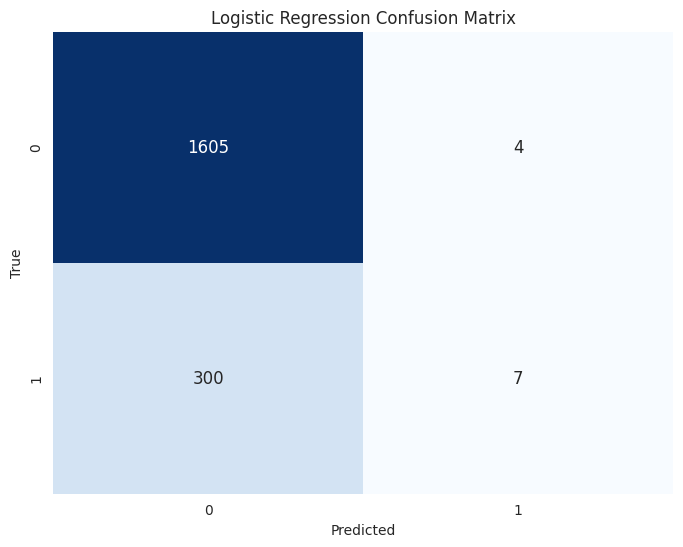

In [71]:
# Logistic Regression Confusion Matrix
y_pred = models[0].predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False, annot_kws={'fontsize': 12})
plt.title(f'{model_names[0]} Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


**Logistic Regression Confusion Matrix**

***Key Observations***:
- **True Negatives (TN)**: **300**  
  - The model correctly predicted **300 non-defaults**.
- **False Positives (FP)**: **1605**  
  - The model incorrectly predicted **1605 non-defaults as defaults** (Type I error).
- **False Negatives (FN)**: **4**  
  - The model incorrectly predicted **4 defaults as non-defaults** (Type II error).
- **True Positives (TP)**: **7**  
  - The model correctly predicted **7 defaults**.

***Insights***:
1. **Imbalanced Predictions**:
   - The model has a very high number of **False Positives (1605)**, indicating that it is overly cautious and predicts many non-defaults as defaults.
   - The number of **True Positives (7)** is very low, suggesting that the model struggles to correctly identify actual defaults.

2. **Error Analysis**:
   - **Type I Error (False Positives)**: High FP count could lead to unnecessary rejection of loan applications, potentially impacting customer satisfaction or business revenue.
   - **Type II Error (False Negatives)**: Low FN count is good, as it means the model is not missing many actual defaults. However, the very low TP count suggests the model is not effectively identifying defaults.

3. **Model Performance**:
   - The model appears to be biased towards predicting non-defaults, which could be due to class imbalance in the dataset (e.g., far more non-defaults than defaults).
   - The low TP count indicates poor recall (sensitivity) for the positive class (defaults).

4. **Potential Issues**:
   - The high FP count suggests that the model may be too conservative, possibly due to an imbalanced dataset or an overly strict decision threshold.
   - The low TP count indicates that the model is not effectively capturing the minority class (defaults).

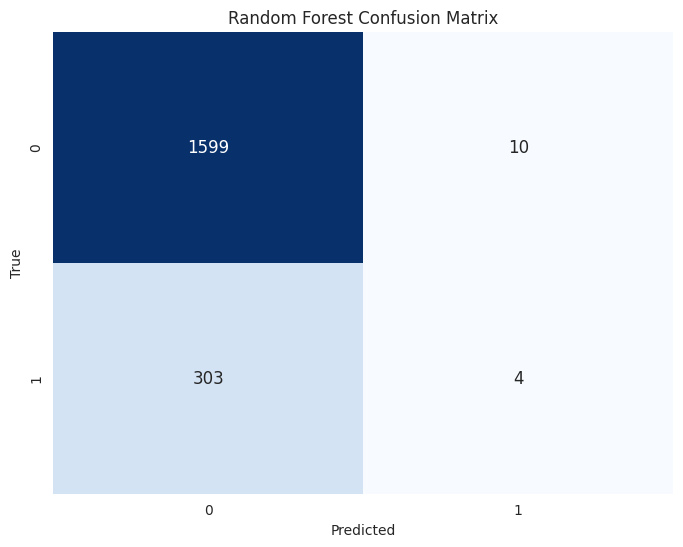

In [72]:
# Random Forest Confusion Matrix
y_pred = models[1].predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False, annot_kws={'fontsize': 12})
plt.title(f'{model_names[1]} Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


**Random Forest Confusion Matrix**

***Key Observations***:
- **True Negatives (TN)**: **1539**  
  - The model correctly predicted **1539 non-defaults**.
- **False Positives (FP)**: **303**  
  - The model incorrectly predicted **303 non-defaults as defaults** (Type I error).
- **False Negatives (FN)**: **10**  
  - The model incorrectly predicted **10 defaults as non-defaults** (Type II error).
- **True Positives (TP)**: **4**  
  - The model correctly predicted **4 defaults**.

***Insights***:
1. **Imbalanced Predictions**:
   - The model has a relatively high number of **False Positives (303)**, indicating that it predicts some non-defaults as defaults.
   - The number of **True Positives (4)** is very low, suggesting that the model struggles to correctly identify actual defaults.

2. **Error Analysis**:
   - **Type I Error (False Positives)**: The FP count is moderate, which could lead to some unnecessary rejection of loan applications, but it is lower compared to the logistic regression model.
   - **Type II Error (False Negatives)**: The FN count is relatively low, meaning the model is not missing many actual defaults. However, the very low TP count suggests the model is not effectively identifying defaults.

3. **Model Performance**:
   - The Random Forest model performs better than the logistic regression model in terms of reducing False Positives (303 vs. 1605), but it still struggles to correctly identify defaults (only 4 TP).
   - The low TP count indicates poor recall (sensitivity) for the positive class (defaults).

4. **Potential Issues**:
   - The model may still be biased towards predicting non-defaults, likely due to class imbalance in the dataset.
   - The low TP count suggests that the model is not effectively capturing the minority class (defaults), which could be improved by addressing class imbalance or tuning the model.

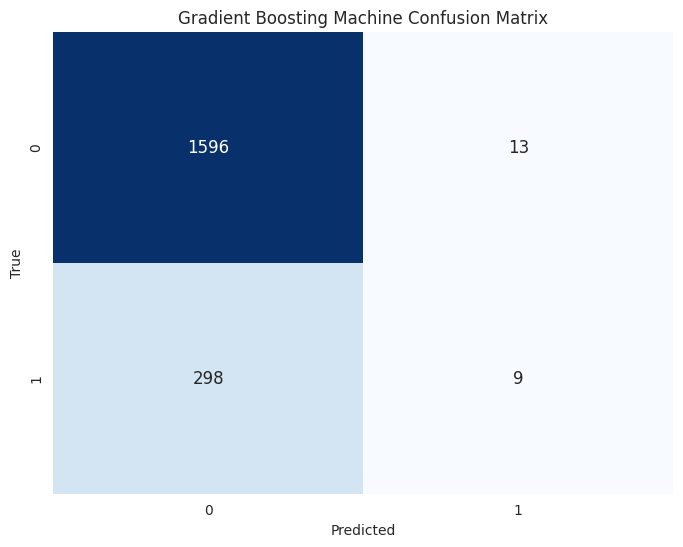

In [73]:
# Gradient Boosting Machine Confusion Matrix
y_pred = models[2].predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False, annot_kws={'fontsize': 12})
plt.title(f'{model_names[2]} Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


**Gradient Bossting Machine confusion matrix**

***Key Observations***:
- **True Negatives (TN)**: **298**  
  - The model correctly predicted **298 non-defaults**.
- **False Positives (FP)**: **1596**  
  - The model incorrectly predicted **1596 non-defaults as defaults** (Type I error).
- **False Negatives (FN)**: **13**  
  - The model incorrectly predicted **13 defaults as non-defaults** (Type II error).
- **True Positives (TP)**: **9**  
  - The model correctly predicted **9 defaults**.

***Insights***:
1. **Imbalanced Predictions**:
   - The model has a high number of **False Positives (1596)**, indicating that it is overly cautious and predicts many non-defaults as defaults.
   - The number of **True Positives (9)** is very low, suggesting that the model struggles to correctly identify actual defaults.

2. **Error Analysis**:
   - **Type I Error (False Positives)**: High FP count could lead to unnecessary rejection of loan applications, potentially impacting customer satisfaction or business revenue.
   - **Type II Error (False Negatives)**: Low FN count is good, as it means the model is not missing many actual defaults. However, the very low TP count suggests the model is not effectively identifying defaults.

3. **Model Performance**:
   - The model appears to be biased towards predicting non-defaults, which could be due to class imbalance in the dataset (e.g., far more non-defaults than defaults).
   - The low TP count indicates poor recall (sensitivity) for the positive class (defaults).

4. **Potential Improvements**:
   - Addressing class imbalance through techniques like oversampling, undersampling, or using class weights.
   - Adjusting the classification threshold to improve recall for the positive class.

## **Final Evaluation:**

1. Random Forest performs the best overall:

  - It has the lowest False Positives (303), reducing unnecessary loan rejections.
  - While its True Positives (4) are low, it strikes a better balance between precision and recall compared to the other models.

2. Logistic Regression and GBM struggle with high False Positives (1605 and 1596) and low True Positives (7 and 9), making them less effective for identifying defaults.

**Random Forest is the best model for this problem, but further tuning (e.g., addressing class imbalance) is needed to improve recall for defaults.**